In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from copy import deepcopy as copy
from scipy.optimize import curve_fit
from scipy.stats import linregress
from matplotlib.colors import LinearSegmentedColormap
import pickle
import pandas as pd
from ast import literal_eval
import json

In [3]:
value_range = 256
color_list = [
    (0,   '#ad262f'),
    (0.5,   'black'),
    (1,   'yellow'),
]
activity_colormap = LinearSegmentedColormap.from_list('activity', color_list, N=value_range)

hsv_cmap = matplotlib.colormaps['hsv']
color_indices = np.linspace(0, 1, 100)
np.random.shuffle(color_indices)
rainbow_colors = hsv_cmap(color_indices)

In [39]:
def write_data(write_path, data):
    f = open(write_path, 'wb')
    pickle.dump(data, f)
    f.close()
    
def load_data(load_path):
    with open(load_path, 'rb') as f:
        return pickle.load(f)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def p_active(w, x, b, g):
    return sigmoid(g * (w * x - b))

def step(x, w, b, g, w_r, t=0):
    p = p_active(w, x[t, :], b + np.sum(w_r * x[t, :]), g)
    x[t + 1, 1:] =  (np.random.rand(p.shape[0]) < p).astype(int)[:-1]
    x[t + 1, 0] = 0
    
def run_activation(w, b, g, w_r):
    x = np.zeros((w.shape[0], w.shape[0])).astype(int)
    x[0, 0] = 1
    for t in range(w.shape[0] - 1):
        step(x, w, b, g, w_r, t)
    return x, w

def make_w_transform_homeostatic(rate, setpoint):
    def w_transform_homeostatic(w, x):
        x_total_activity = np.sum(x, axis=0)
        w[:-1] += rate * (setpoint - x_total_activity[1:])
        return w
    return w_transform_homeostatic

def make_w_transform_seq(rate, setpoint):
    def w_transform_seq(w, x):
        for i in range(len(w) - 1):
            w[i] += rate * np.sum(x[:-1, i] * x[1:, i+1] - x[:-1, i+1] * x[1:, i])
        w = np.minimum(w, setpoint)
        return w
    return w_transform_seq

def make_w_r_transform(rate, setpoint):
    def w_r_transform(w_r, x):
        w_r += rate * x.sum(axis=0)
        w_r = np.minimum(w_r, setpoint)
        return w_r
    return w_r_transform

def make_dropout(p):
    def dropout(w, w_r):
        fracs_remaining = np.random.binomial(100, 1-p, size=w.shape[0]) / 100
        return fracs_remaining * w, fracs_remaining * w_r
    return dropout      

def run_n_activations(w_0, b, g, w_r_0, n, w_transform=None, w_r_transform=None, dropout_iter=1000, dropout_func=None):
    all_weights = []
    w = copy(w_0)
    w_r = copy(w_r_0)
    sequential_activity = []
    all_activity = []
    sequential_activity_with_blowups = []
    for i in range(n):
        if i == dropout_iter:
            w, w_r = dropout_func(w, w_r)
        x, w = run_activation(w, b, g, w_r)
        
        x_seq = np.zeros((x.shape[0]))
        s = 0
        while s < len(x_seq) and x[s, s] == 1 and (x[s, :s] == 0).all() and (x[s, s+1:] == 0).all():
            x_seq[s] = 1
            s += 1
        sequential_activity.append(x_seq)
        all_activity.append(copy(x))
        sequential_activity_with_blowups.append(sequential_activity[-1])
        
        if i > dropout_iter and w_transform is not None:
            w = w_transform(w, x)    
            
        if i > dropout_iter and w_r_transform is not None:
            w_r = w_r_transform(w_r, x) 
            
        all_weights.append(copy(w))
    return np.array(sequential_activity), np.array(all_activity), np.array(sequential_activity_with_blowups), np.array(all_weights)
    
def extract_lengths(X):
    l = np.zeros(X.shape[0])
    x_prod = np.ones(X.shape[0])
    for i in range(X.shape[1]):
        l += (X[:, i] * x_prod)
        x_prod *= X[:, i]
    l = np.where(X[:, 0] < 0, 0, l)
    return l

def extract_first_hitting_times(X_all, benchmark_lens, start=10):
    all_times = []
    for i_X, X in enumerate(X_all):
        times = np.nan * np.ones(len(benchmark_lens))
        counter = 0
        ls = extract_lengths(X)
        for j, l in enumerate(ls[start:]):
            if counter < len(times) and l >= benchmark_lens[counter]:
                while counter < len(times) and l >= benchmark_lens[counter]:
                    times[counter] = j
                    counter += 1
        all_times.append(times)
    return np.array(all_times)

def extract_jumps(X_all):
    all_hitting_times = extract_first_hitting_times(X_all, np.arange(1, 51))
    all_jump_size_counts = []
    
    for hitting_times in all_hitting_times:
        
        last_hitting_time = None
        jump_sizes_count = np.zeros((50,))
        jump_size = 0
        for i, hitting_time in enumerate(shave_front_zeros_except_last(hitting_times)):
            if last_hitting_time is None:
                last_hitting_time = hitting_time
            elif last_hitting_time == hitting_time:
                jump_size += 1
            else:
                jump_sizes_count[jump_size] += 1
                jump_size = 1
            last_hitting_time = hitting_time
        jump_sizes_count[jump_size] += 1
        all_jump_size_counts.append(jump_sizes_count)
    return np.array(all_jump_size_counts)

def determine_recovered(X_all, n_activations=20, threshold=0.8, n_cells=50):
    recovered_vec = np.zeros((len(X_all),))
    for i_X, X in enumerate(X_all):
        ls = extract_lengths(X)
        recovered = (np.count_nonzero(ls[-n_activations:] == n_cells) / n_activations) > threshold
        recovered_vec[i_X] = recovered
    return recovered_vec 

def shave_front_zeros_except_last(arr):
    for i, x in enumerate(arr):
        if x != 0:
            if i == 0:
                return arr
            else:
                return arr[i-1:]
    return np.array([])
    

In [1135]:
w_0 = 10 * np.ones(50)
g = 2
steps = 100
completion_percentages = np.zeros((steps, steps))

for i_b, b in enumerate(np.linspace(0, 10, steps)):
    for i_w_r, w_r_pre in enumerate(np.linspace(0, 10, steps)):
        w_r = w_r_pre * np.ones(50)
        sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 50)
        completion_percentage = np.count_nonzero(np.sum(sawbu, axis=1) == sawbu.shape[1]) / sawbu.shape[0]
        completion_percentages[i_b, i_w_r] = completion_percentage

/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_6798/2949740151.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [1142]:
write_data('data/completion_percentages.pickle', completion_percentages)

[Text(0, 0.0, '0.0'),
 Text(0, 24.75, '2.5'),
 Text(0, 49.5, '5.0'),
 Text(0, 74.25, '7.5'),
 Text(0, 99.0, '10.0')]

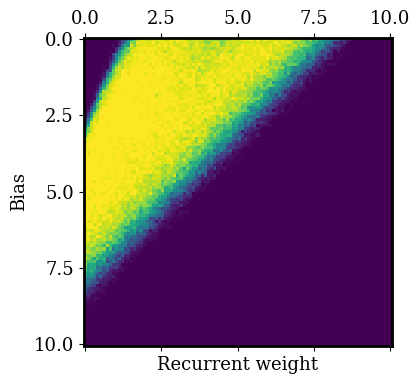

In [1152]:
completion_percentages_2 = load_data('data/completion_percentages.pickle')
scale = 4
fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
ax.matshow(completion_percentages_2)
ax.set_ylabel('Bias')
ax.set_xlabel('Recurrent weight')
ax.set_xticks(np.linspace(0, 99, 5))
ax.set_xticklabels(np.linspace(0, 10, 5))
ax.set_yticks(np.linspace(0, 99, 5))
ax.set_yticklabels(np.linspace(0, 10, 5))


In [218]:
w_0 = 10 * np.ones(50)
b = 1
w_r = 5 * np.ones(50)
g = 2
sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 300)

0
50
100
150
200
250


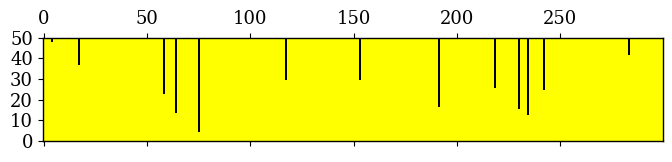

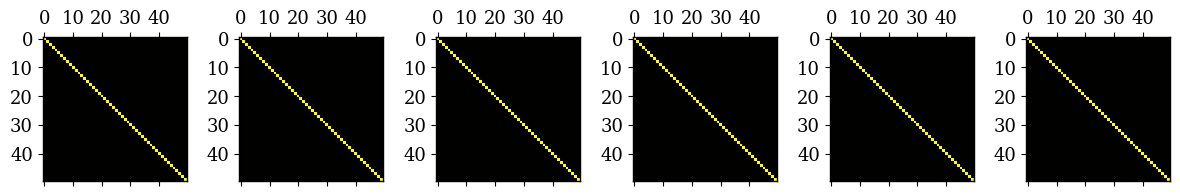

In [219]:
plt.rc('font', family='serif')
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.

scale = 8
fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
cbar = ax.matshow(sawbu.T, vmax=1, vmin=-1, cmap=activity_colormap)
ax.set_ylim(0, sawbu.shape[1])


scale = 2
r = np.arange(0, aa.shape[0], 50)
fig, ax = plt.subplots(1, len(r), figsize=(len(r) * scale, 1 * scale))
for i, activation_i in enumerate(r):
    print(activation_i)
    cbar = ax[i].matshow(aa[activation_i, :], vmax=1, vmin=-1, cmap=activity_colormap)
fig.tight_layout()

In [42]:
w_0 = 10 * np.ones(50)
b = 2.5
w_r = 2.5 * np.ones(50)
g = 2
sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 300, make_w_transform_homeostatic(1, 1), make_w_r_transform(0.01, 5), dropout_iter=10, dropout_func=make_dropout(0.5))

21.6
0
50
100
150
200
250


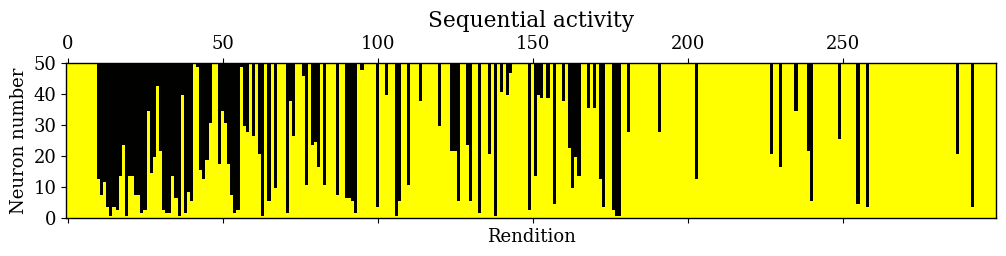

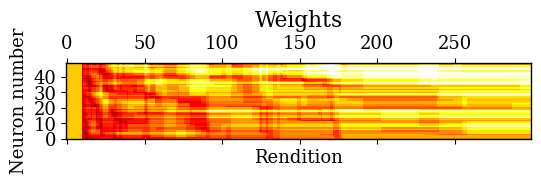

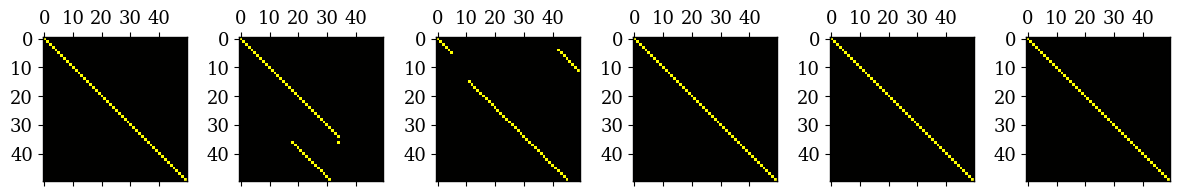

In [43]:
plt.rc('font', family='serif')
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.

scale = 6
fig, ax = plt.subplots(1, figsize=(2 * scale, 1 * scale))
cbar = ax.matshow(sa.T, vmax=1, vmin=-1, cmap=activity_colormap)
# plt.colorbar(cbar)
ax.set_ylim(0, sa.shape[1])
ax.set_ylabel('Neuron number')
ax.set_xlabel('Rendition')
ax.set_title('Sequential activity')

fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
cbar = ax.matshow(ws.T, cmap='hot', vmin=0, vmax=15)
print(ws.max())
# plt.colorbar(cbar)
ax.set_ylim(0, ws.shape[1] - 1)
ax.set_ylabel('Neuron number')
ax.set_xlabel('Rendition')
ax.set_title('Weights')

scale = 2
r = np.arange(0, aa.shape[0], 50)
fig, ax = plt.subplots(1, len(r), figsize=(len(r) * scale, 1 * scale))
for i, activation_i in enumerate(r):
    print(activation_i)
    cbar = ax[i].matshow(aa[activation_i, :], vmax=1, vmin=-1, cmap=activity_colormap)
fig.tight_layout()

In [37]:
w_0 = 10 * np.ones(50)
b = 0
w_r = 5 * np.ones(50)
g = 2
sas_for_activations = []
sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 300, make_w_transform_seq(0.4, 10), make_w_r_transform(0.01, 5), dropout_iter=10, dropout_func=make_dropout(0.5))
sas_for_activations.append(sawbu)

10.0
0
25
50
75
100
125
150
175
200
225
250
275


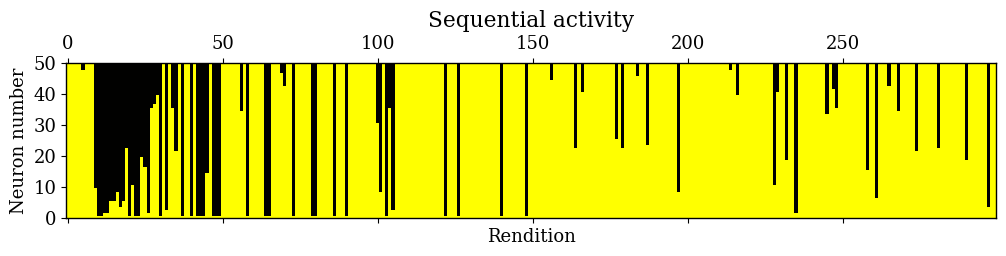

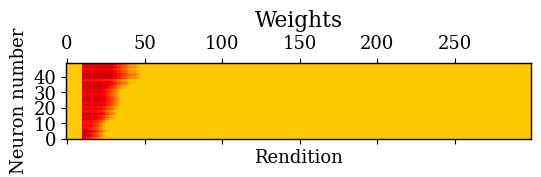

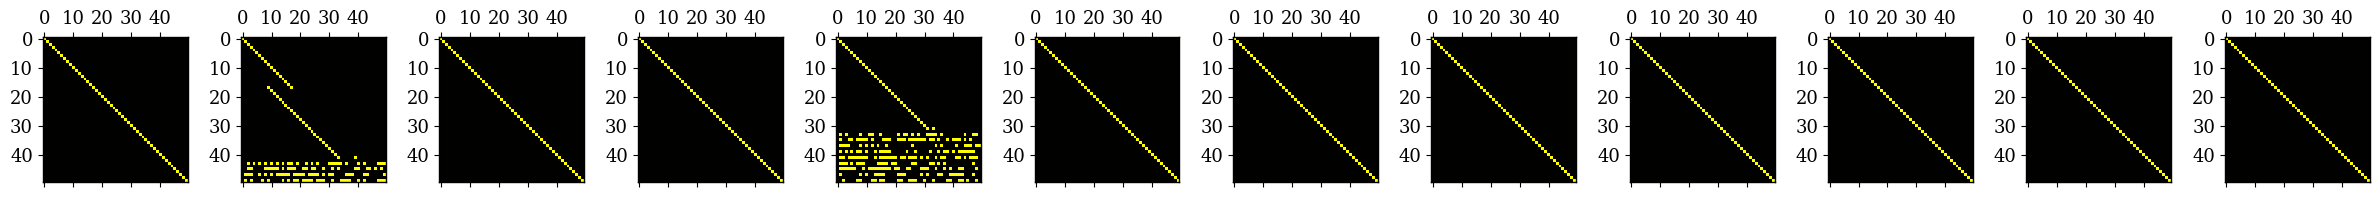

In [38]:
plt.rc('font', family='serif')
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.

scale = 6
fig, ax = plt.subplots(1, figsize=(2 * scale, 1 * scale))
cbar = ax.matshow(sa.T, vmax=1, vmin=-1, cmap=activity_colormap)
# plt.colorbar(cbar)
ax.set_ylim(0, sa.shape[1])
ax.set_ylabel('Neuron number')
ax.set_xlabel('Rendition')
ax.set_title('Sequential activity')

fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
cbar = ax.matshow(ws.T, cmap='hot', vmin=0, vmax=15)
# plt.colorbar(cbar)
print(ws.max())
ax.set_ylim(0, ws.shape[1] - 1)
ax.set_ylabel('Neuron number')
ax.set_xlabel('Rendition')
ax.set_title('Weights')

scale = 2
r = np.arange(0, aa.shape[0], 25)
fig, ax = plt.subplots(1, len(r), figsize=(len(r) * scale, 1 * scale))
for i, activation_i in enumerate(r):
    print(activation_i)
    cbar = ax[i].matshow(aa[activation_i, :], vmax=1, vmin=-1, cmap=activity_colormap)
fig.tight_layout()

In [247]:
w_0 = 10 * np.ones(50)
b = 0
w_r = 5 * np.ones(50)
g = 2
sas_for_activations = []
sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 300, None, make_w_r_transform(0.01, 5), dropout_iter=10, dropout_func=make_dropout(0.4))
sas_for_activations.append(sawbu)

10.0


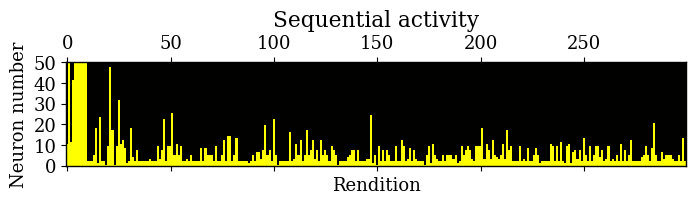

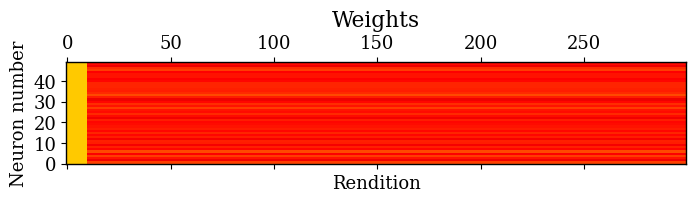

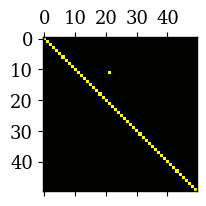

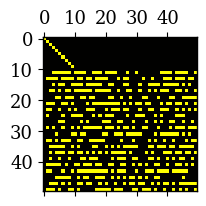

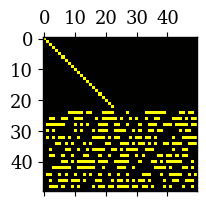

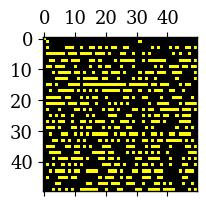

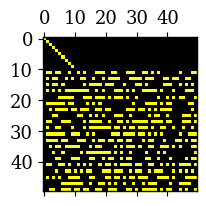

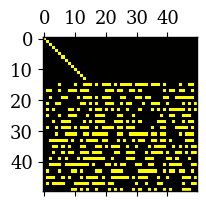

In [248]:
plt.rc('font', family='serif')
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.

scale = 8
fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
cbar = ax.matshow(sa.T, vmax=1, vmin=-1, cmap=activity_colormap)
# plt.colorbar(cbar)
ax.set_ylim(0, sa.shape[1])
ax.set_ylabel('Neuron number')
ax.set_xlabel('Rendition')
ax.set_title('Sequential activity')

fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
cbar = ax.matshow(ws.T, cmap='hot', vmin=0, vmax=15)
# plt.colorbar(cbar)
print(ws.max())
ax.set_ylim(0, ws.shape[1] - 1)
ax.set_ylabel('Neuron number')
ax.set_xlabel('Rendition')
ax.set_title('Weights')

for i in range(0, aa.shape[0], 50):
    scale = 2
    fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
    cbar = ax.matshow(aa[i, :], vmax=1, vmin=-1, cmap=activity_colormap)

In [1108]:
w_0 = 12 * np.ones(50)
b = 4
w_r = 4 * np.ones(50)

X_across_dropouts = []
dropout_percentages = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]

for dropout in dropout_percentages: 
    X_parallel = []
    for i in range(100):
        sa, nsa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 300,  make_w_transform_homeostatic(0.05, 1), dropout_iter=10, dropout_func=make_dropout(dropout))
        X_parallel.append(sawbu)

    X_seq = []
    for i in range(100):
        sa, nsa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 300, make_w_transform_seq(0.1, 12), dropout_iter=10, dropout_func=make_dropout(dropout))
        X_seq.append(sawbu)
    
    X_across_dropouts.append([X_parallel, X_seq])

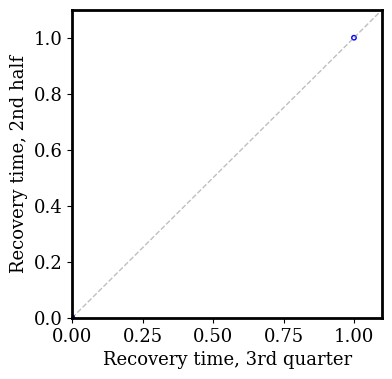

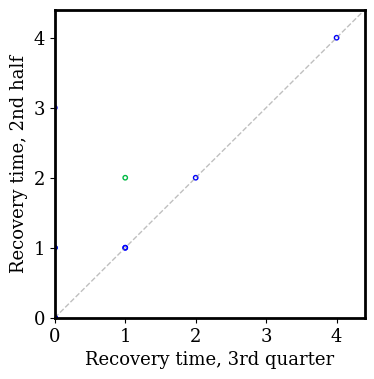

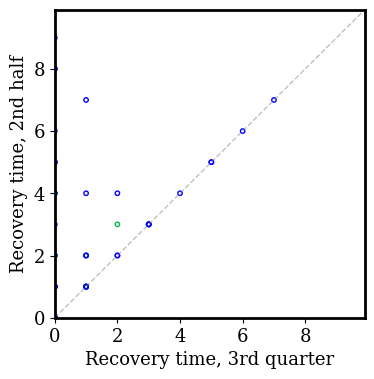

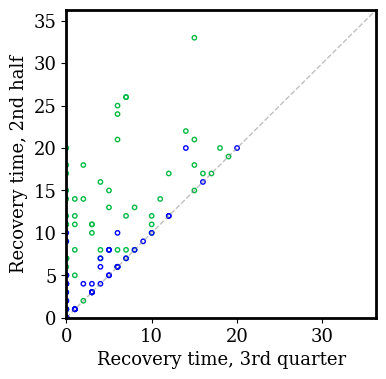

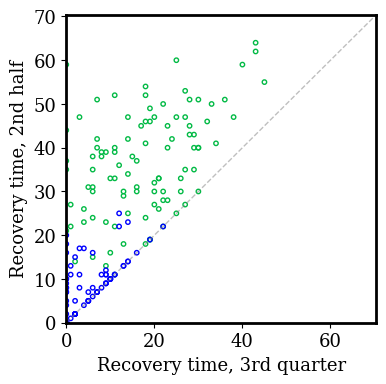

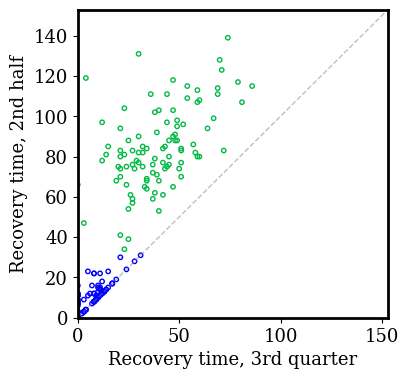

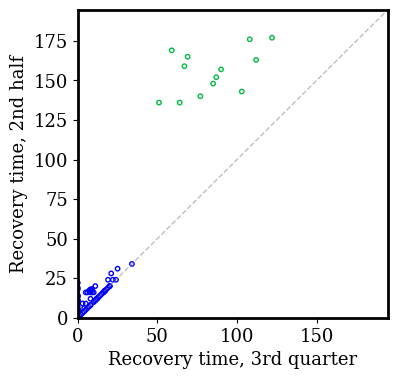

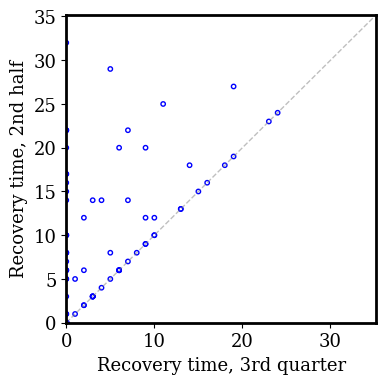

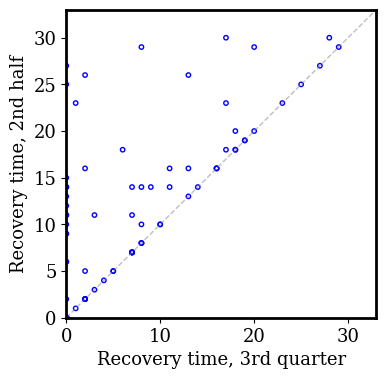

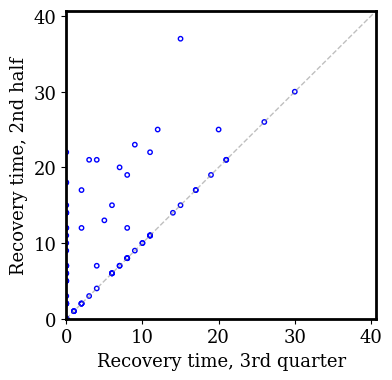

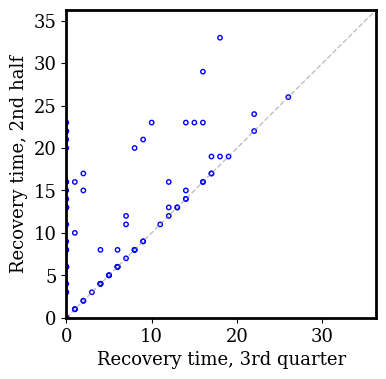

In [1103]:
for dropout_i in range(len(X_across_dropouts)):
    
    X_parallel, X_seq = X_across_dropouts[dropout_i]
        
    hitting_times_seq = extract_first_hitting_times(X_seq, [25, 37, 50])
    hitting_times_parallel = extract_first_hitting_times(X_parallel, [25, 37, 50])
    
    scale = 4
    fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
    
    ax.plot(np.arange(300), np.arange(300), '--', lw=1, alpha=0.5, color='gray')
    
    hitting_times_seq = hitting_times_seq[hitting_times_seq[:, 0] > 0, :]
    hitting_time_seq_partial = hitting_times_seq[:, 1] - hitting_times_seq[:, 0]
    hitting_time_seq_full = hitting_times_seq[:, 2] - hitting_times_seq[:, 0]
    
    ax.scatter(hitting_times_seq[:, 1] - hitting_times_seq[:, 0], hitting_times_seq[:, 2] - hitting_times_seq[:, 0], edgecolor='#02ba45', facecolor='none', marker='o', s=10)
    
    hitting_times_parallel = hitting_times_parallel[hitting_times_parallel[:, 0] > 0, :]
    hitting_time_parallel_partial = hitting_times_parallel[:, 1] - hitting_times_parallel[:, 0]
    hitting_time_parallel_full = hitting_times_parallel[:, 2] - hitting_times_parallel[:, 0]
    ax.scatter(hitting_times_parallel[:, 1] - hitting_times_parallel[:, 0], hitting_times_parallel[:, 2] - hitting_times_parallel[:, 0], edgecolor='blue', facecolor='none', marker='o', s=10)

    ax.set_xlabel('Recovery time, 3rd quarter')
    ax.set_ylabel('Recovery time, 2nd half')
    
    max_time = np.nanmax(np.concatenate([hitting_time_seq_partial, hitting_time_seq_full, hitting_time_parallel_partial, hitting_time_parallel_full]))
    ax.set_xlim(0, 1.1 * max_time)
    ax.set_ylim(0, 1.1 * max_time)

In [1062]:
r_squareds_parallel = []
r_squareds_seq = []

for dropout_i in range(len(X_across_dropouts)):
    
    X_parallel, X_seq = X_across_dropouts[dropout_i]
    
    hitting_times_parallel = extract_first_hitting_times(X_parallel, np.arange(1, 51))
    hitting_times_seq = extract_first_hitting_times(X_seq, np.arange(1, 51))
    
    r_values_parallel = []
    for i in range(len(hitting_times_parallel)):
        if (hitting_times_parallel[i] != 0).any() and (hitting_times_parallel[i][-1] > 0 or np.isnan(hitting_times_parallel[i][-1])):
            slope, intercept, r_value, p_value, std_err = linregress(np.arange(hitting_times_parallel.shape[1]), hitting_times_parallel[i])
            r_values_parallel.append(np.square(r_value))
     
    r_values_seq = []
    for i in range(len(hitting_times_seq)):
        if (hitting_times_seq[i] != 0).any() and hitting_times_seq[i][-1] > 0:
            slope, intercept, r_value, p_value, std_err = linregress(np.arange(hitting_times_seq.shape[1]), hitting_times_seq[i])
            r_values_seq.append(np.square(r_value))
            
    r_squareds_parallel.append(np.mean(r_values_parallel))
    r_squareds_seq.append(np.mean(r_values_seq))

Text(0.5, 0, 'Dropout percentage')

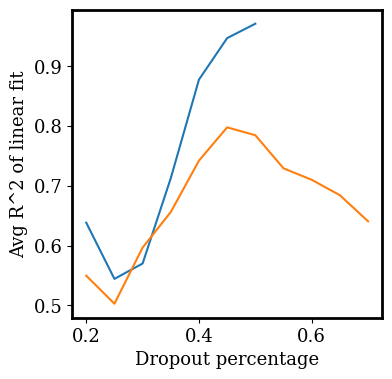

In [1063]:
scale = 4
fig, axs = plt.subplots(1, figsize=(1 * scale, 1 * scale))

axs.plot(dropout_percentages, r_squareds_seq)
axs.plot(dropout_percentages, r_squareds_parallel)
axs.set_ylabel('Avg R^2 of linear fit')
axs.set_xlabel('Dropout percentage')

In [15]:
def plot_salt_vs_seq_statistics(X_parallel_across_dropouts, X_seq_across_dropouts, subtitle='', plot_runs=False):
    parallel_broken_count = []
    parallel_recovered_count = []
    stdp_broken_count = []
    stdp_recovered_count = []

    parallel_seq_count = []
    parallel_salt_count = []
    stdp_seq_count = []
    stdp_salt_count = []


    for dropout_i in range(len(X_parallel_across_dropouts)):

        X_parallel, X_seq = X_parallel_across_dropouts[dropout_i], X_seq_across_dropouts[dropout_i]
        
        recovered_parallel = determine_recovered(X_parallel)
        recovered_seq = determine_recovered(X_seq)
        
        hitting_times_parallel = extract_first_hitting_times(X_parallel, np.arange(1, 51))
        hitting_times_seq = extract_first_hitting_times(X_seq, np.arange(1, 51))

        max_hitting_time = np.nanmax(np.concatenate([hitting_times_parallel.flatten(), hitting_times_seq.flatten()]))

        all_jumps_parallel = extract_jumps(X_parallel)
        all_jumps_seq = extract_jumps(X_seq)
        
        
        if plot_runs:
            scale = 7
            fig, axs = plt.subplots(2, 2, figsize=(1 * scale, 1 * scale))

        seq_count = 0
        salt_count = 0

        broken_count = 0
        recovered_count = 0

        plotted_count_seq = 0
        plotted_count_parallel = 0

        for i in range(len(hitting_times_parallel)):
            cropped_hitting_time = shave_front_zeros_except_last(hitting_times_parallel[i])
            recovered = recovered_parallel[i]

            if np.isnan(hitting_times_parallel[i]).any() or hitting_times_parallel[i][-1] > 0:
                broken_count += 1

            if cropped_hitting_time.shape[0] > 0 and recovered:
                recovered_count += 1
                activation_lengths = np.arange(51 - cropped_hitting_time.shape[0], 51)
                if all_jumps_parallel[i][25:].sum() == 0:  
                    if plotted_count_seq < 5:
                        if plot_runs:
                            axs[0, 1].plot(cropped_hitting_time, activation_lengths, color=rainbow_colors[i])
                        plotted_count_seq += 1
                    seq_count += 1
                else:
                    if plotted_count_parallel < 5:
                        if plot_runs:
                            axs[0, 0].plot(cropped_hitting_time, activation_lengths, color=rainbow_colors[i])
                        plotted_count_parallel += 1
                    salt_count += 1

        parallel_broken_count.append(broken_count)
        parallel_recovered_count.append(recovered_count)
        parallel_seq_count.append(seq_count)
        parallel_salt_count.append(salt_count)

        if plot_runs:
            axs[0, 0].set_title(f'Homeostatic\nsaltatory {salt_count} of {seq_count + salt_count}')
            axs[0, 1].set_title(f'Homeostatic\nsequential {seq_count} of {seq_count + salt_count}')

        seq_count = 0
        salt_count = 0

        broken_count = 0
        recovered_count = 0

        plotted_count_seq = 0
        plotted_count_parallel = 0

        for i in range(len(hitting_times_seq)):
            cropped_hitting_time = shave_front_zeros_except_last(hitting_times_seq[i])
            recovered = recovered_seq[i]

            if np.isnan(hitting_times_seq[i]).any() or hitting_times_seq[i][-1] > 0:
                broken_count += 1
            
            if cropped_hitting_time.shape[0] > 0 and recovered:
                recovered_count += 1
                activation_lengths = np.arange(51 - cropped_hitting_time.shape[0], 51)
                if all_jumps_seq[i][25:].sum() == 0:    
                    if plotted_count_seq < 5:
                        if plot_runs:
                            axs[1, 1].plot(cropped_hitting_time, activation_lengths, color=rainbow_colors[i])
                        plotted_count_seq += 1
                    seq_count += 1
                else:
                    if plotted_count_parallel < 5:
                        if plot_runs:
                            axs[1, 0].plot(cropped_hitting_time, activation_lengths, color=rainbow_colors[i])
                        plotted_count_parallel += 1
                    salt_count += 1

        stdp_broken_count.append(broken_count)
        stdp_recovered_count.append(recovered_count)
        stdp_seq_count.append(seq_count)
        stdp_salt_count.append(salt_count)

        if plot_runs:
            axs[1, 0].set_title(f'STDP\nsaltatory {salt_count} of {seq_count + salt_count}')
            axs[1, 1].set_title(f'STDP\nsequential {seq_count} of {seq_count + salt_count}')

        if plot_runs:
            for j in range(2):
                for k in range(2):
                    axs[j, k].set_ylim(0, 50)
                    if ~np.isnan(max_hitting_time):
                        axs[j, k].set_xlim(0, max_hitting_time)
                    axs[j, k].set_ylabel('Activation length')
                    axs[j, k].set_xlabel('First hitting time')

            fig.tight_layout()

    scale = 6
    fig, axs = plt.subplots(1, 1, figsize=(1.4 * scale, 0.55 * scale))

    parallel_broken_count = np.array(parallel_broken_count)
    parallel_recovered_count = np.array(parallel_recovered_count)
    stdp_broken_count = np.array(stdp_broken_count)
    stdp_recovered_count = np.array(stdp_recovered_count)

    axs.bar(np.arange(0, 3 * len(parallel_broken_count), 3), parallel_broken_count, color='white', edgecolor='blue')
    axs.bar(np.arange(0, 3 * len(parallel_broken_count), 3), parallel_recovered_count, color='blue', edgecolor='blue')
    axs.bar(np.arange(1, 3 * len(parallel_broken_count) + 1, 3), stdp_broken_count, color='white', edgecolor='#02ba45')
    axs.bar(np.arange(1, 3 * len(parallel_broken_count) + 1, 3), stdp_recovered_count, color='#02ba45', edgecolor='#02ba45')

    axs.set_xticks(np.arange(0.5, 3 * len(parallel_broken_count) + 0.5, 3))
    axs.set_xticklabels(dropout_percentages)

    axs.set_xlabel('Dropout percentage')
    axs.set_ylabel('Count')
    axs.set_title(f'Recovery rates{subtitle}')

    scale = 6
    fig, axs = plt.subplots(1, 1, figsize=(1.4 * scale, 0.55 * scale))

    parallel_seq_count = np.array(parallel_seq_count)
    parallel_salt_count = np.array(parallel_salt_count)
    stdp_seq_count = np.array(stdp_seq_count)
    stdp_salt_count = np.array(stdp_salt_count)

    axs.bar(np.arange(0, 3 * len(parallel_salt_count), 3), parallel_seq_count + parallel_salt_count, color='white', edgecolor='blue', hatch='//')
    axs.bar(np.arange(0, 3 * len(parallel_salt_count), 3), parallel_salt_count, color='blue', edgecolor='blue')
    axs.bar(np.arange(1, 3 * len(parallel_salt_count) + 1, 3), stdp_seq_count + stdp_salt_count, color='white', edgecolor='#02ba45', hatch='//')
    axs.bar(np.arange(1, 3 * len(parallel_salt_count) + 1, 3), stdp_salt_count, color='#02ba45', edgecolor='#02ba45')

    axs.set_xticks(np.arange(0.5, 3 * len(parallel_broken_count) + 0.5, 3))
    axs.set_xticklabels(dropout_percentages)

    axs.set_xlabel('Dropout percentage')
    axs.set_ylabel('Count')
    axs.set_title('Saltatory vs. sequential recovery')

<Figure size 640x480 with 0 Axes>

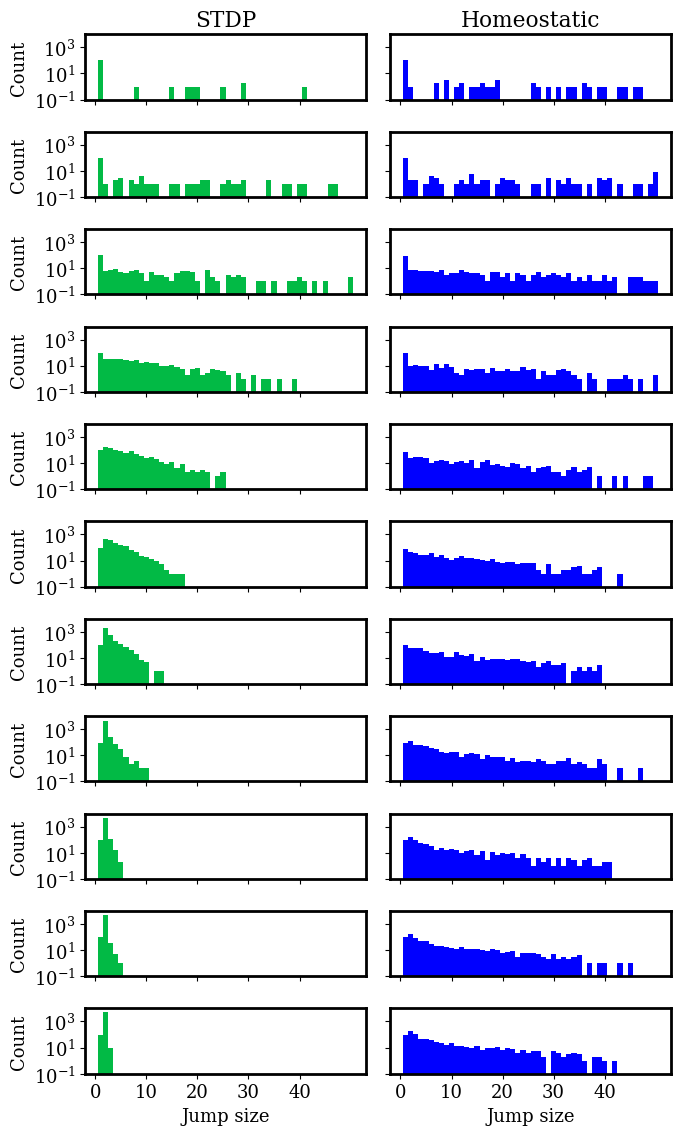

In [1083]:
plt.rc('font', family='serif')
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 2.
plt.subplots_adjust(wspace=0, hspace=0.05)

scale = 7
fig, axs = plt.subplots(len(X_across_dropouts), 2, figsize=(1 * scale, 0.15 * len(X_across_dropouts) * scale), sharex=True, sharey=True)

for dropout_i in range(len(X_across_dropouts)):
    
    X_parallel, X_seq = X_across_dropouts[dropout_i]
    
    jump_size_counts_parallel = extract_jumps(X_parallel).sum(axis=0)
    jump_size_counts_seq = extract_jumps(X_seq).sum(axis=0)
    
    max_count = np.maximum(np.max(jump_size_counts_parallel), np.max(jump_size_counts_seq))
    
    axs[dropout_i, 0].bar(np.arange(1, len(jump_size_counts_seq) + 1), jump_size_counts_seq, width=1, color='#02ba45')
    axs[dropout_i, 1].bar(np.arange(1, len(jump_size_counts_parallel) + 1), jump_size_counts_parallel, width=1, color='blue')
    
    for i in range(2):
        axs[dropout_i, i].set_yscale('log')
        axs[dropout_i, i].set_xticks(np.arange(0, 50, 10))
        axs[dropout_i, i].set_ylim(1e-1, 2 * max_count)
    
    axs[dropout_i, 0].set_ylabel('Count')
    
axs[0, 0].set_title(f'STDP')
axs[0, 1].set_title(f'Homeostatic')
axs[-1, 0].set_xlabel('Jump size')
axs[-1, 1].set_xlabel('Jump size')
            
fig.tight_layout()

In [44]:
run_name = 'param_sweep_4'

w_0 = 10 * np.ones(50)

bias_w_r_start = np.array([5, 0])
bias_w_r_end = np.array([0, 5])
bias_w_r_points = 5
dropout_percentages = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
learning_rates = [0.1, 1, 10]
inh_learning_rate = 0.01
n_networks = 30

In [45]:
total_points = bias_w_r_points * len(learning_rates) * len(dropout_percentages) * 2
print('total points:', total_points)


df = None
point_count = 0

for p in np.linspace(0, 1, bias_w_r_points):
    w_r_b_vec = bias_w_r_start * (1-p) + bias_w_r_end * p
    w_r_0, b = w_r_b_vec[0], w_r_b_vec[1]
    w_r = w_r_0 * np.ones(50)
    
    for rate in learning_rates:
        for dropout in dropout_percentages: 
            X_ctrl = []
            for i in range(n_networks):
                sa, nsa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 300, None, None, dropout_iter=10, dropout_func=make_dropout(dropout))
                X_ctrl.append(sawbu)
            X_ctrl = np.array(X_ctrl)
                
            data = {
                'rule': ['none'],
                'rate': [rate],
                'w_r': [w_r_0],
                'b' : [b],
                'dropout': [dropout],
                'activations': [list(X_ctrl.flatten().astype(int))],
                'activations_shape': [X_ctrl.shape],
            }
            
            if df is None:
                df = pd.DataFrame(data)
                df.to_csv(f'data/{run_name}.csv', index=False)
            else:
                df = pd.DataFrame(data)
                df.to_csv(f'data/{run_name}.csv', index=False, mode='a', header=False)
                
            print(point_count)
            point_count += 1
            
            
            X_homeo = []
            for i in range(n_networks):
                sa, nsa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 300,  make_w_transform_homeostatic(rate, 1), make_w_r_transform(inh_learning_rate, w_r_0), dropout_iter=10, dropout_func=make_dropout(dropout))
                X_homeo.append(sawbu)
            X_homeo = np.array(X_homeo)
                
            data = {
                'rule': ['homeostatic'],
                'rate': [rate],
                'w_r': [w_r_0],
                'b' : [b],
                'dropout': [dropout],
                'activations': [list(X_homeo.flatten().astype(int))],
                'activations_shape': [X_homeo.shape],
            }
            
            if df is None:
                df = pd.DataFrame(data)
                df.to_csv(f'data/{run_name}.csv', index=False)
            else:
                df = pd.DataFrame(data)
                df.to_csv(f'data/{run_name}.csv', index=False, mode='a', header=False)
                
            print(point_count)
            point_count += 1
                

            X_stdp = []
            for i in range(n_networks):
                sa, nsa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 300, make_w_transform_seq(rate, 10), make_w_r_transform(inh_learning_rate, w_r_0), dropout_iter=10, dropout_func=make_dropout(dropout))
                X_stdp.append(sawbu)
            X_stdp = np.array(X_stdp)
            
            data = {
                'rule': ['stdp'],
                'rate': [rate],
                'w_r': [w_r_0],
                'b' : [b],
                'dropout': [dropout],
                'activations': [list(X_stdp.flatten().astype(int))],
                'activations_shape': [X_stdp.shape],
            }
            
            if df is None:
                df = pd.DataFrame(data)
                df.to_csv(f'data/{run_name}.csv', index=False)
            else:
                df = pd.DataFrame(data)
                df.to_csv(f'data/{run_name}.csv', index=False, mode='a', header=False)
                
            print(point_count)
            point_count += 1

total points: 330
0


/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_31525/879692710.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


1
2
3


/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_31525/879692710.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


4
5
6


/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_31525/879692710.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


7
8
9


/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_31525/879692710.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


10
11
12


/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_31525/879692710.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


13
14
15


/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_31525/879692710.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


16
17
18


/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_31525/879692710.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


19
20
21


/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_31525/879692710.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


22
23
24


/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_31525/879692710.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


25



KeyboardInterrupt



In [40]:
df = pd.read_csv('data/param_sweep_3.csv')

/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_31525/32377476.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, 2, figsize=(1 * scale, 1 * scale))


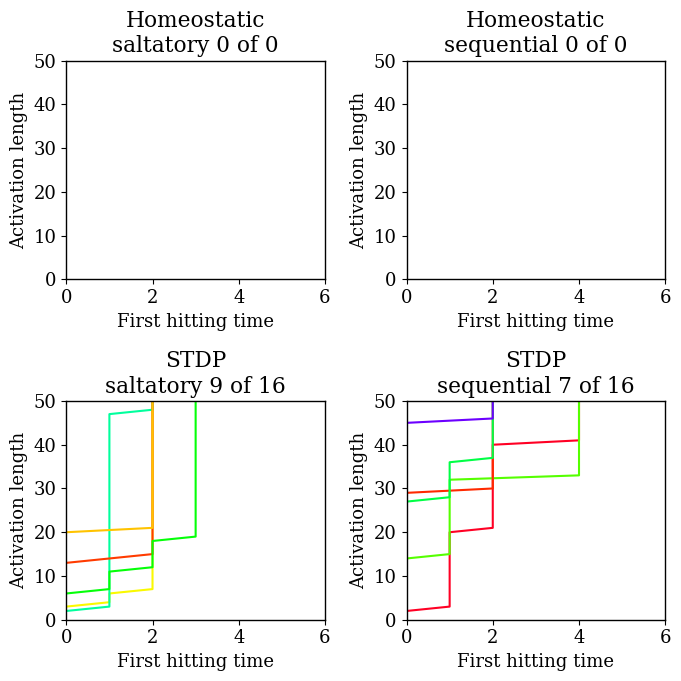

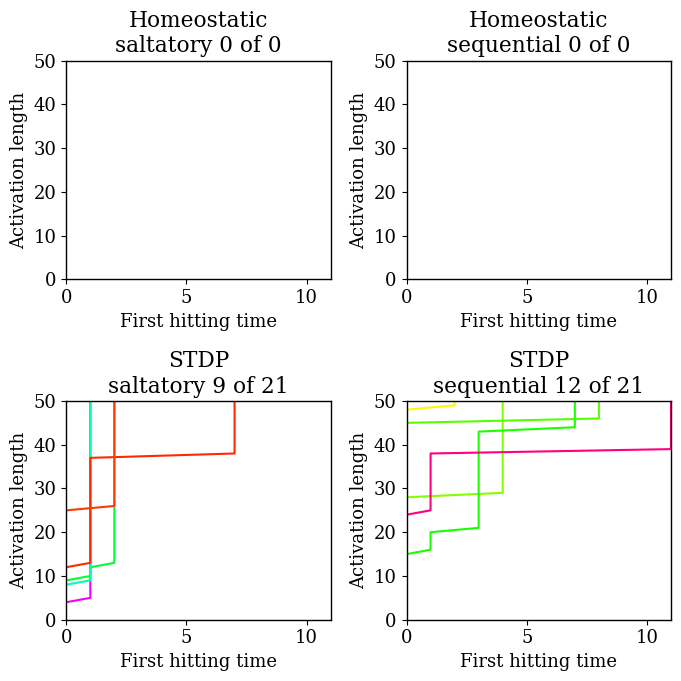

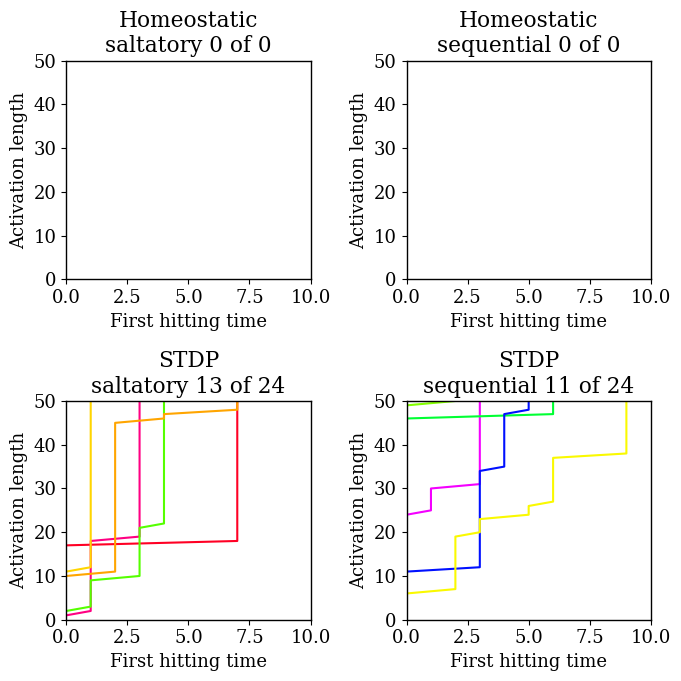

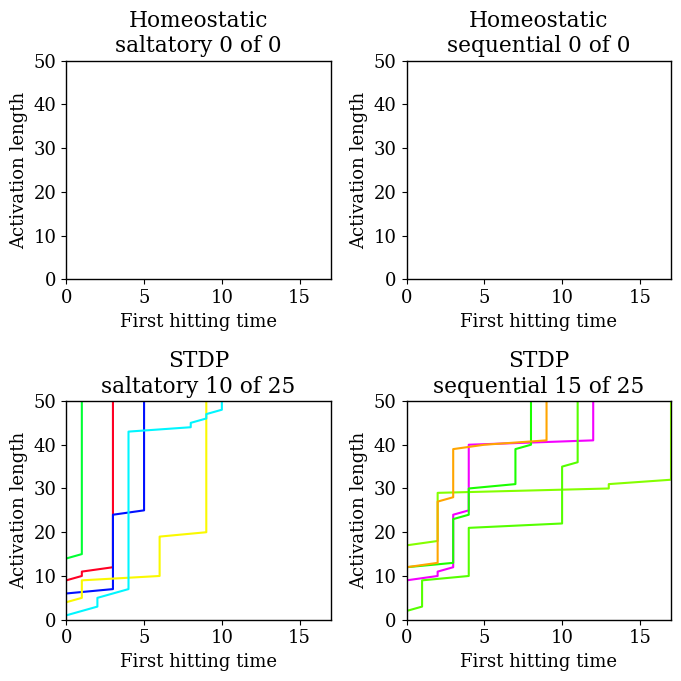

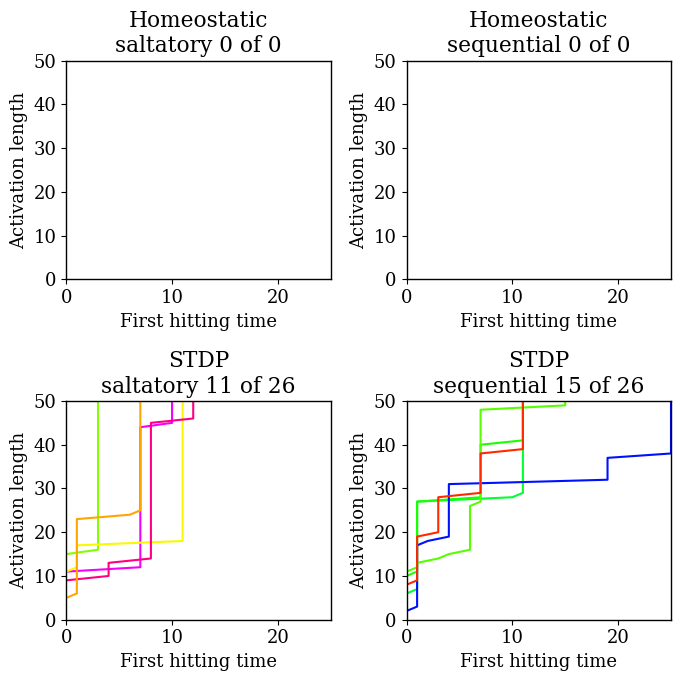

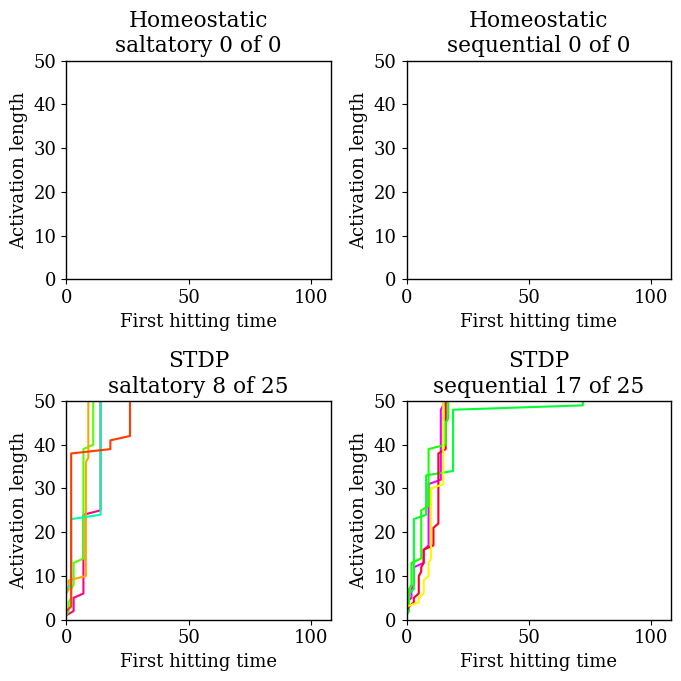

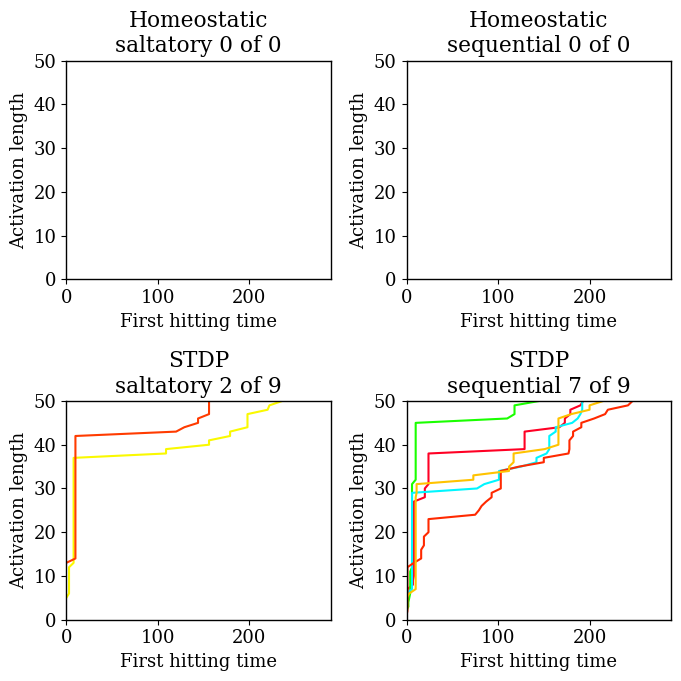

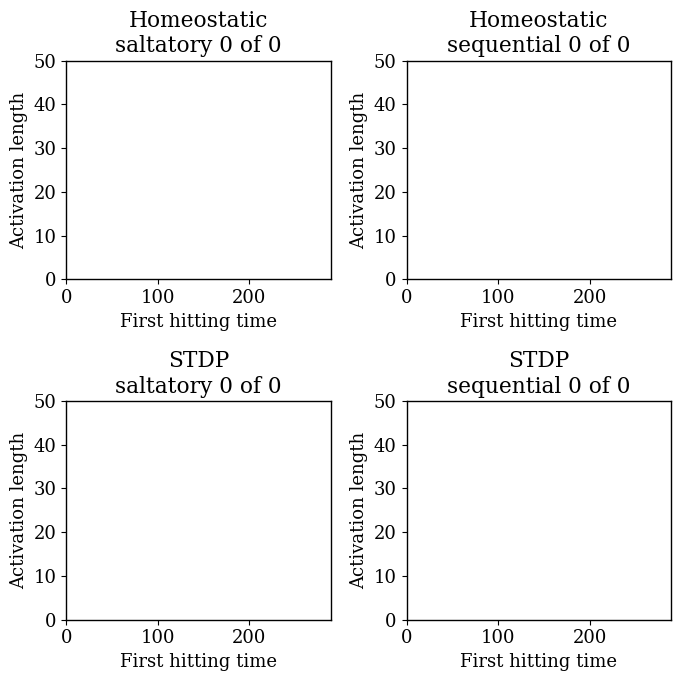

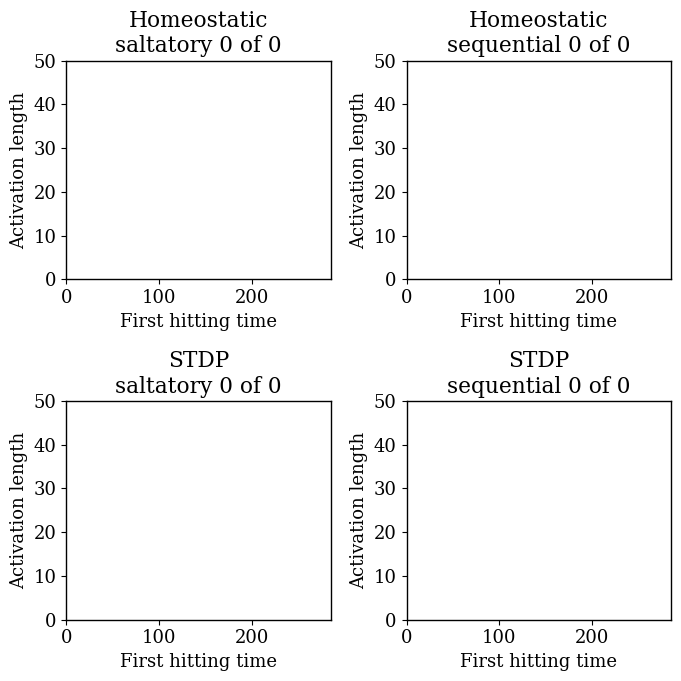

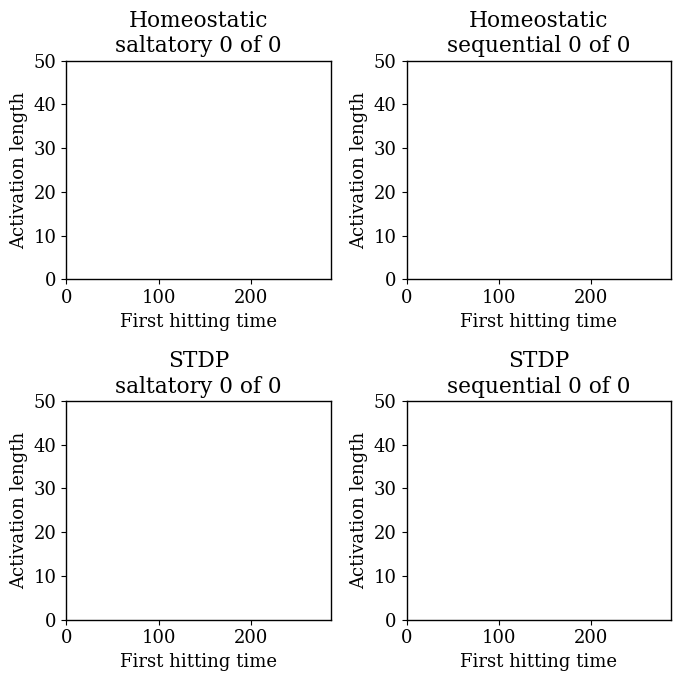

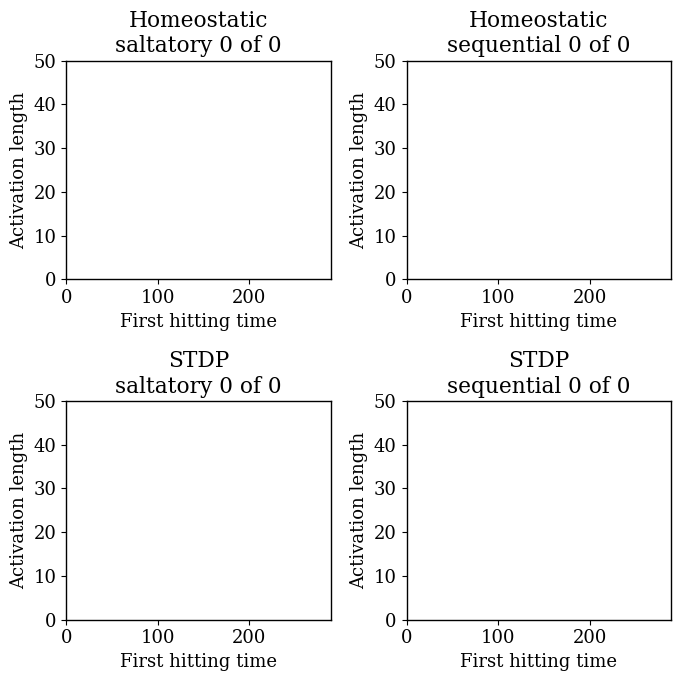

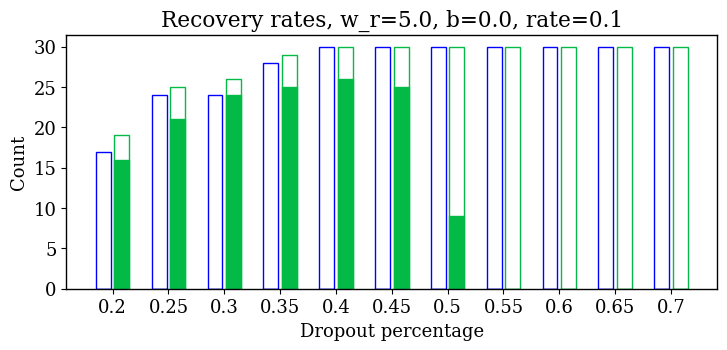

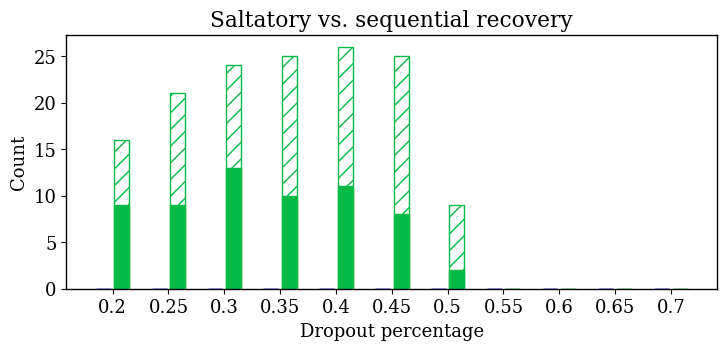

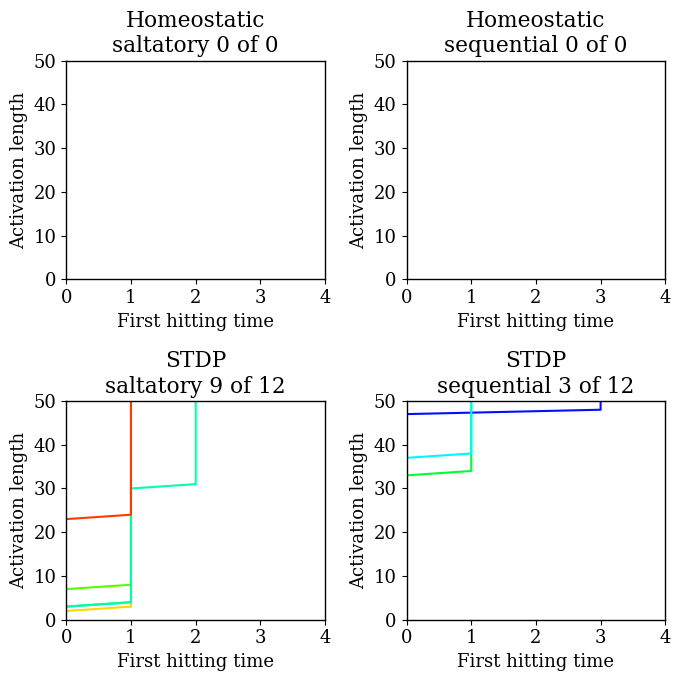

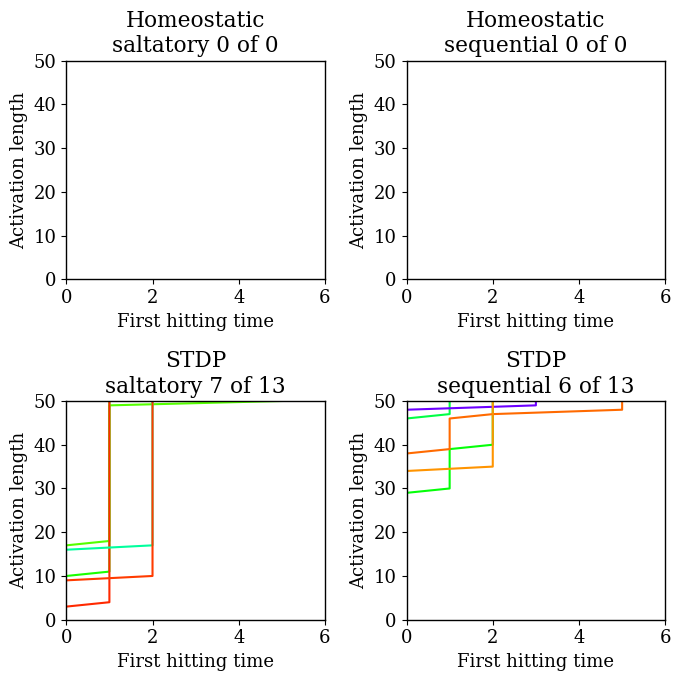

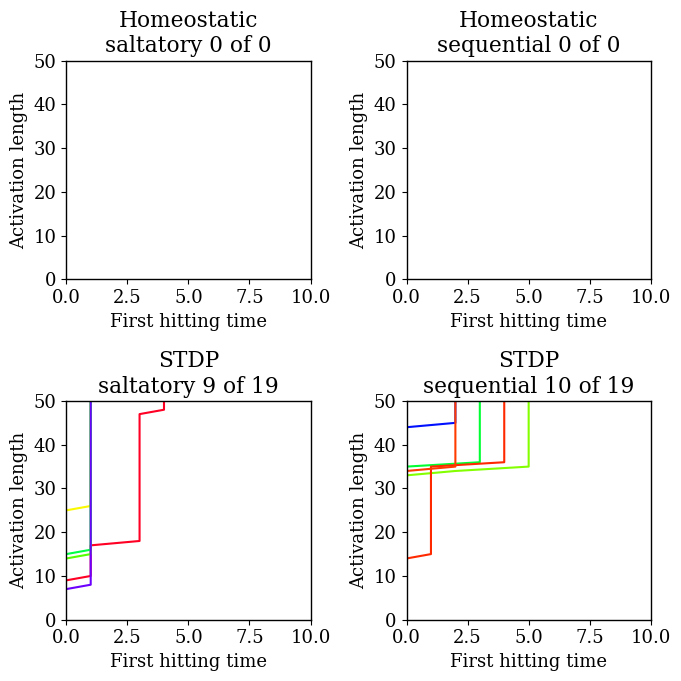

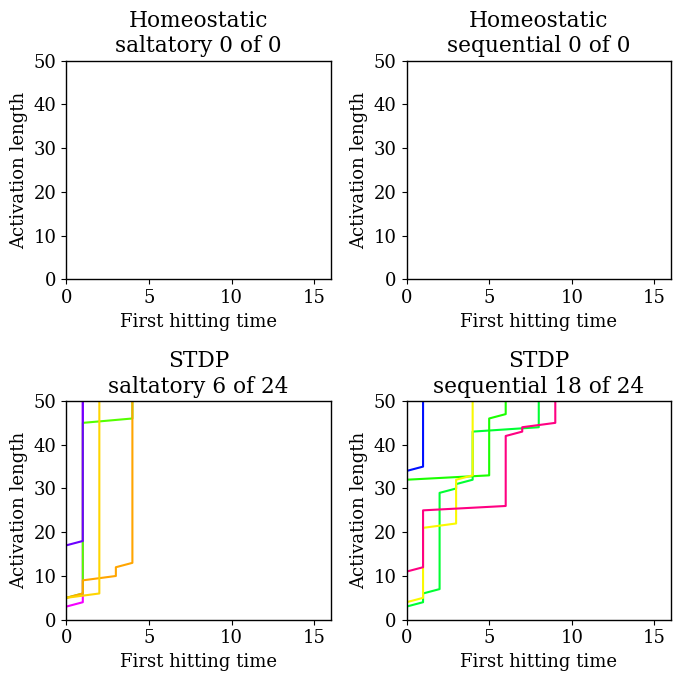

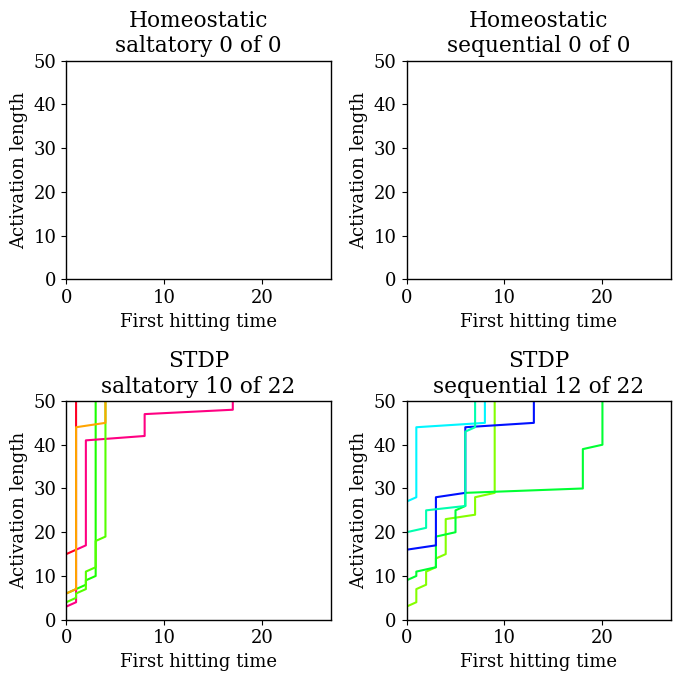

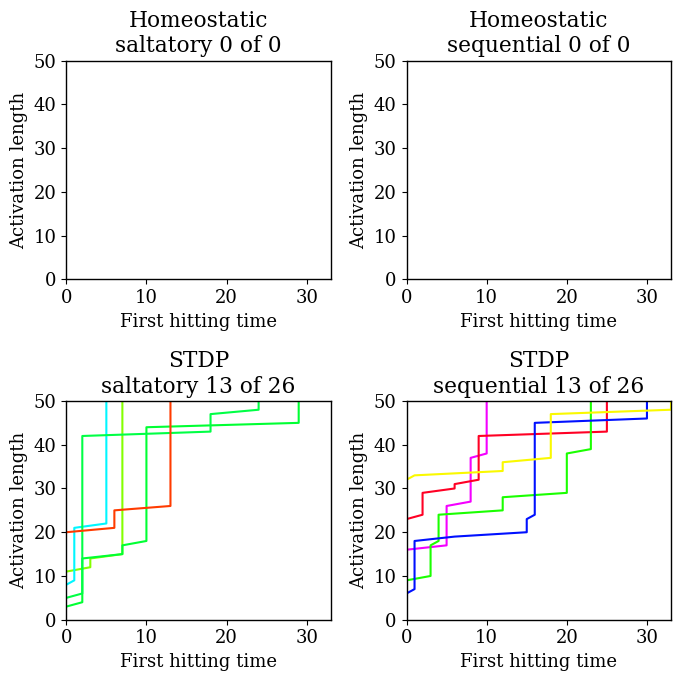

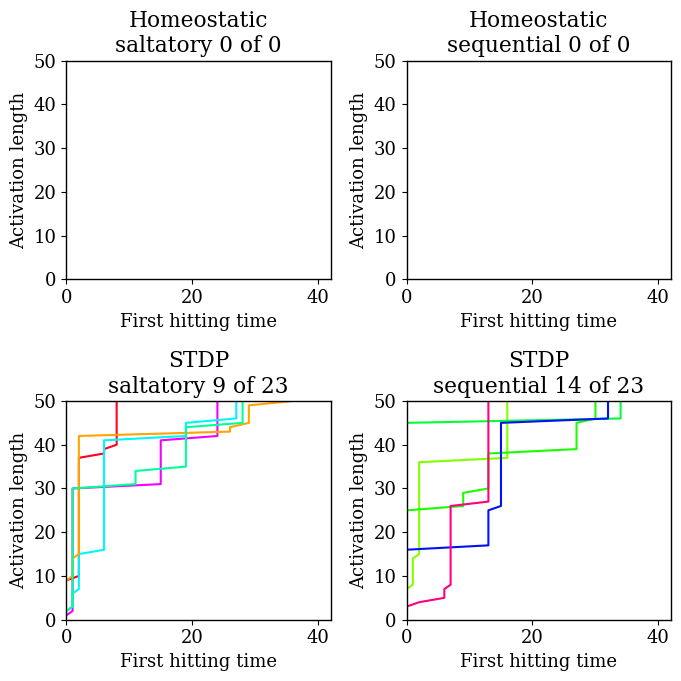

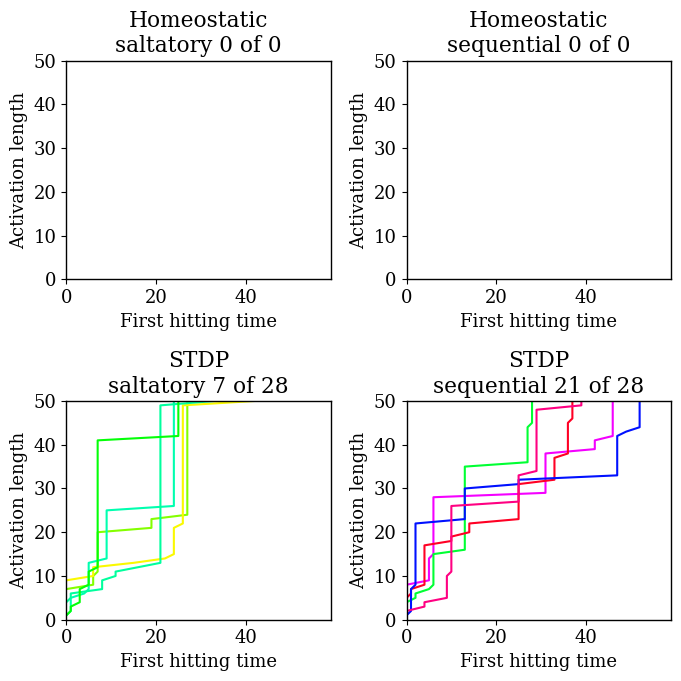

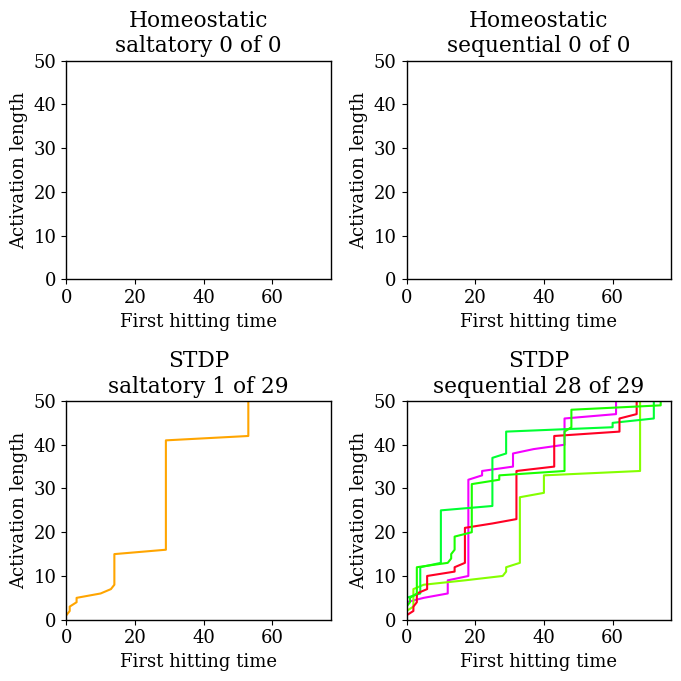

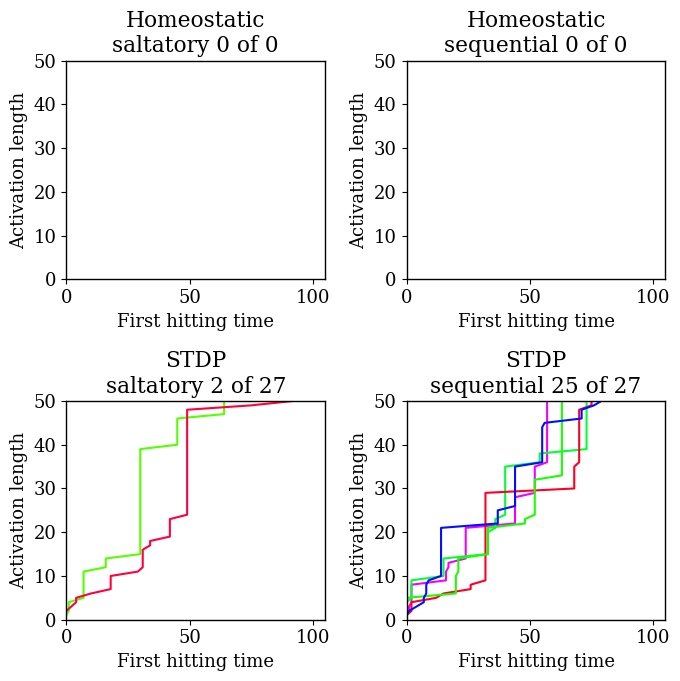

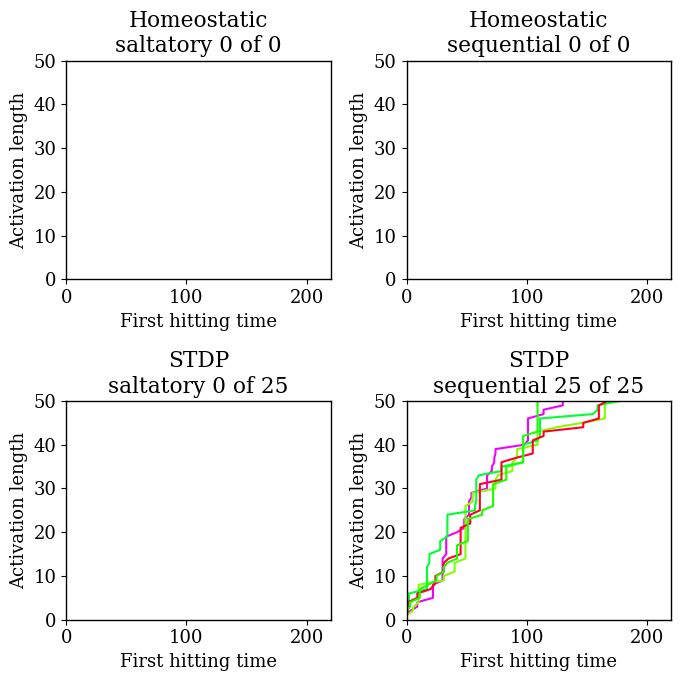

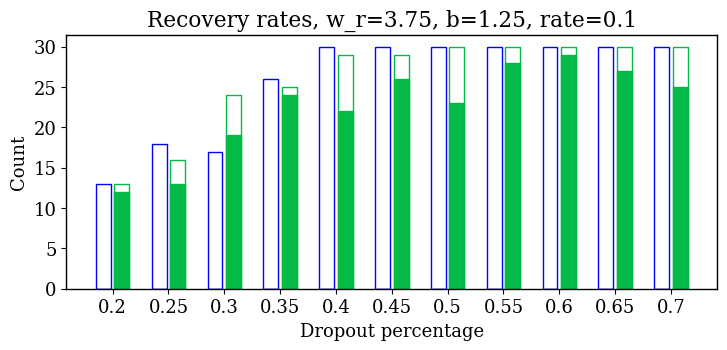

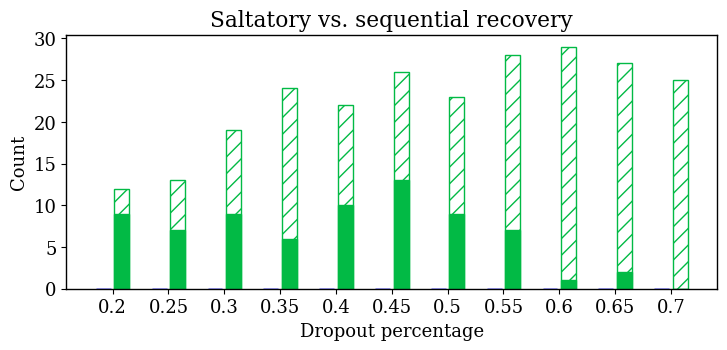

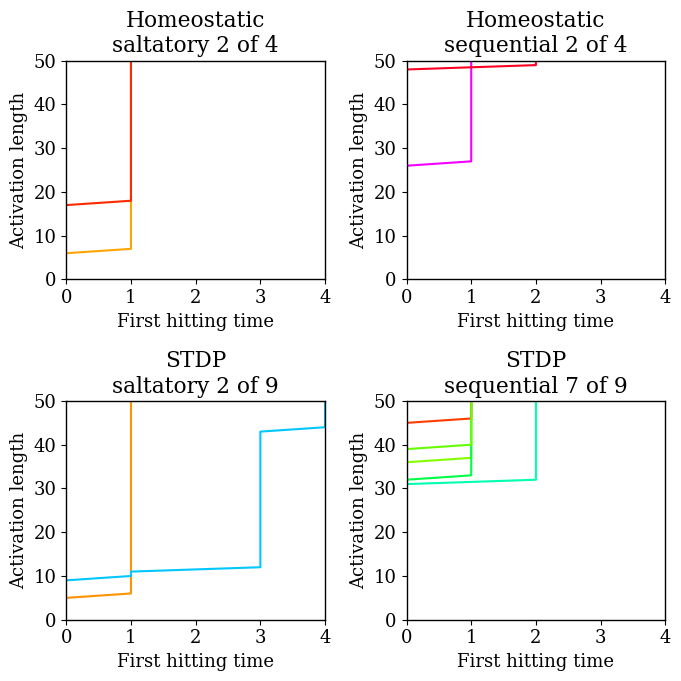

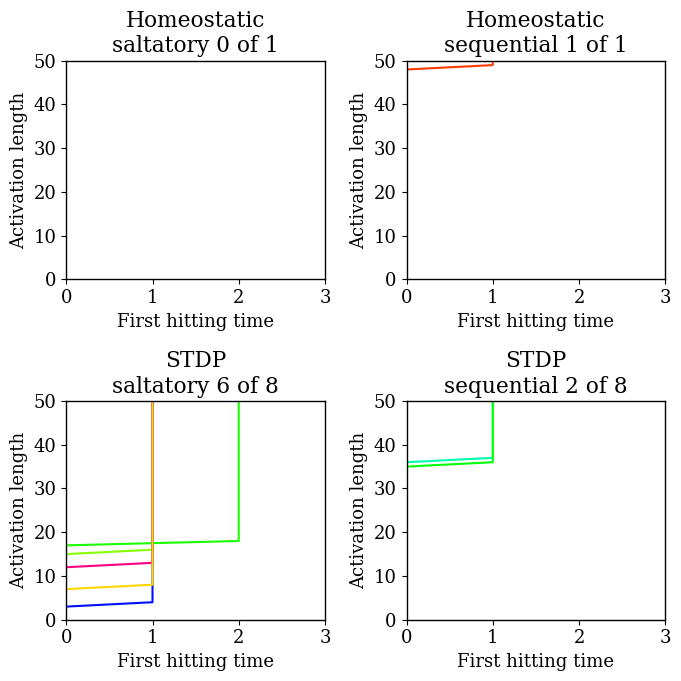

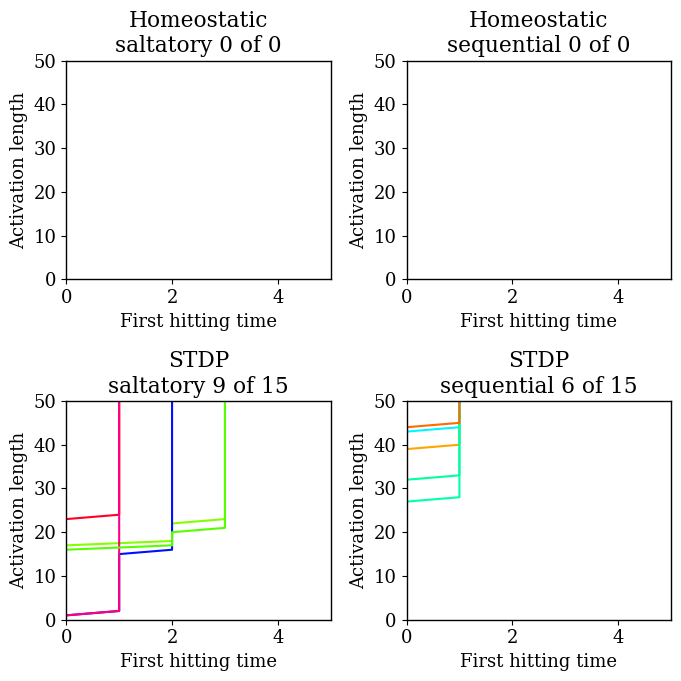

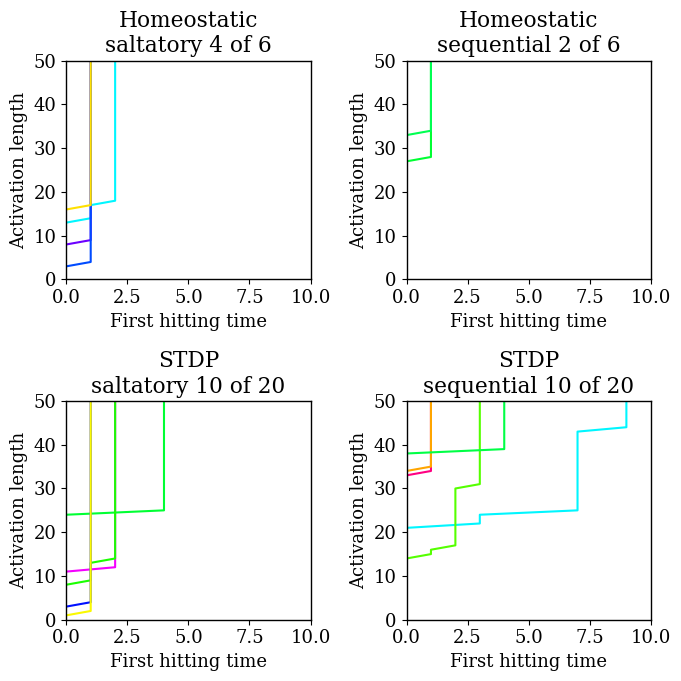

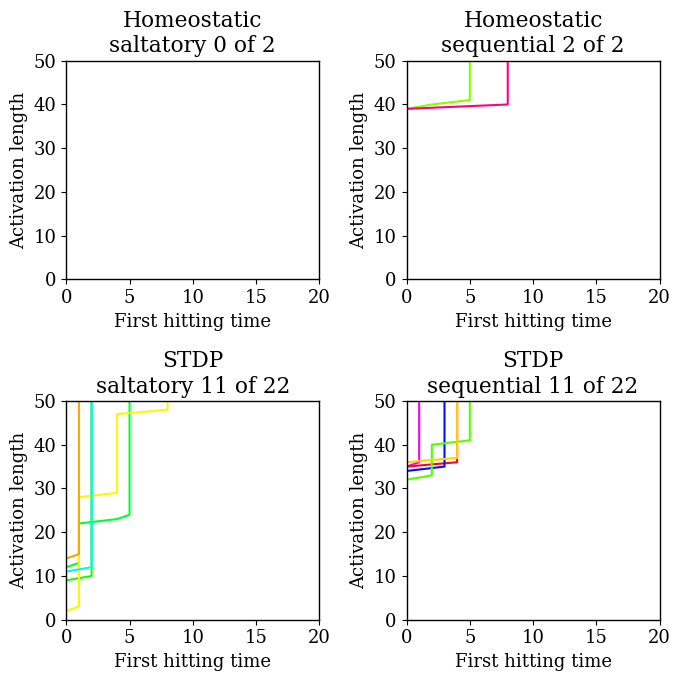

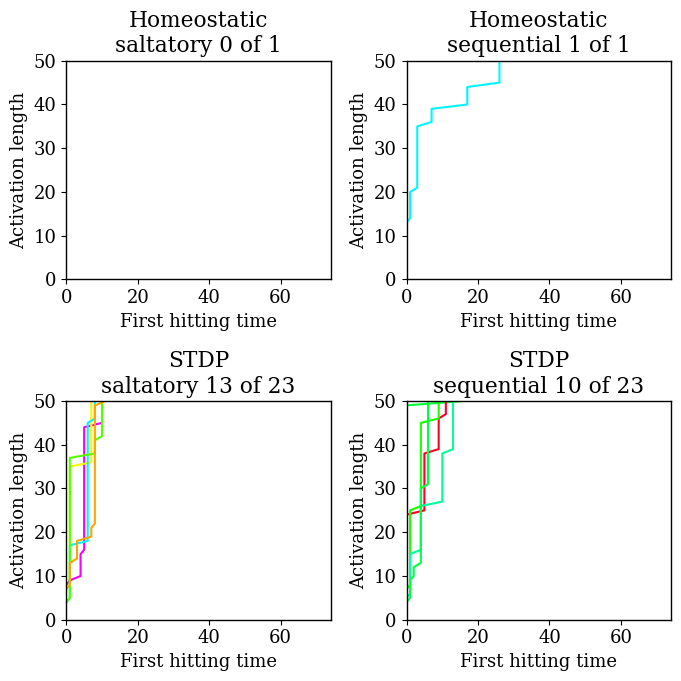

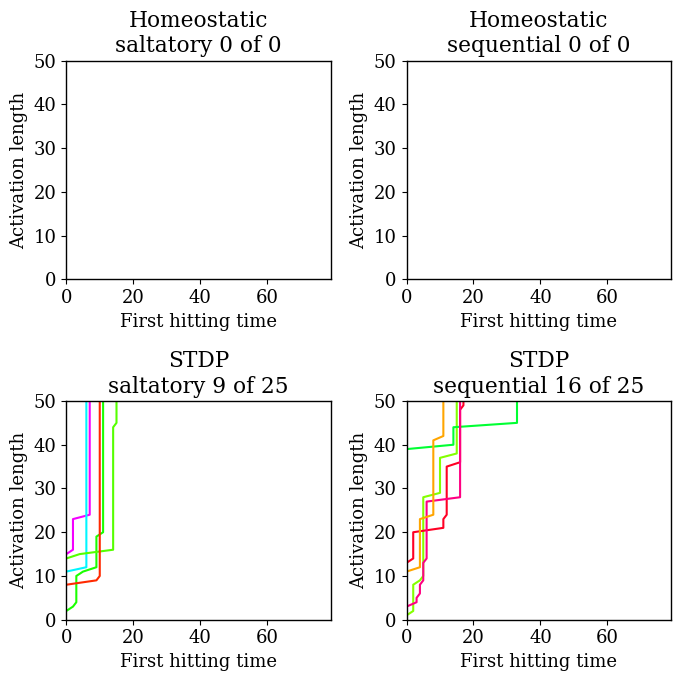

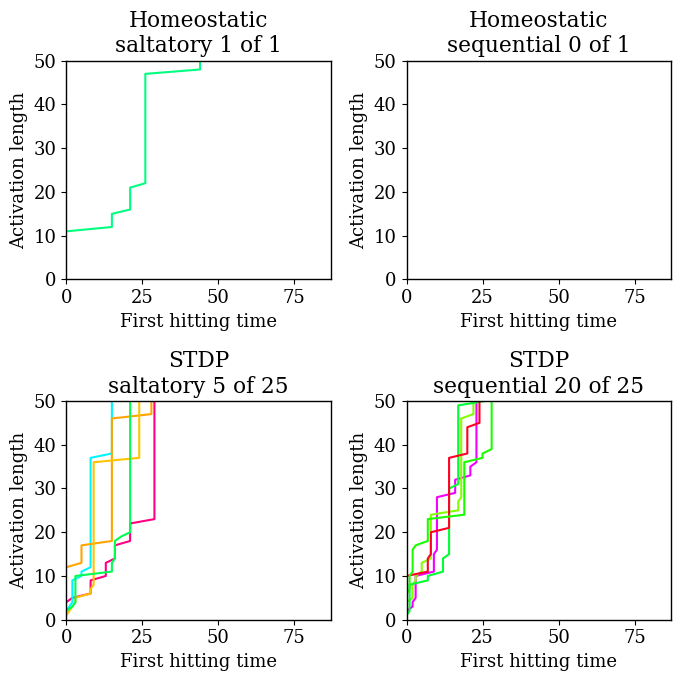

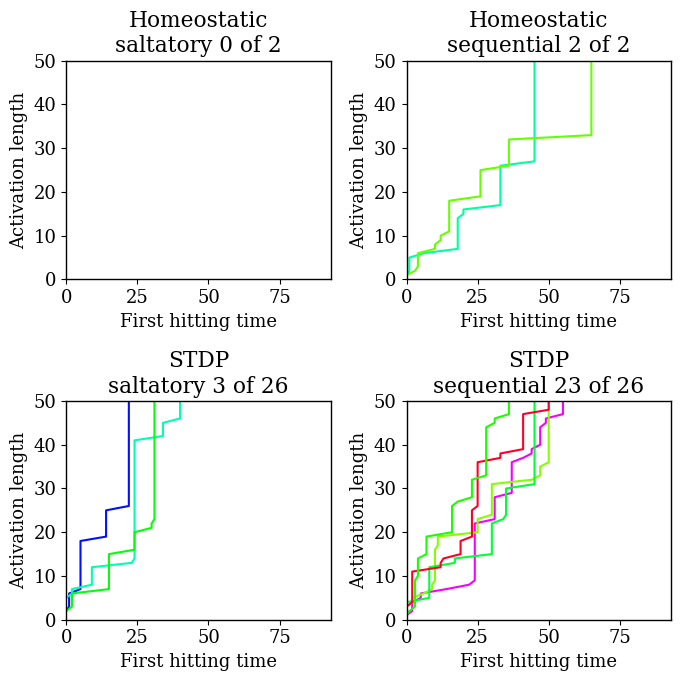

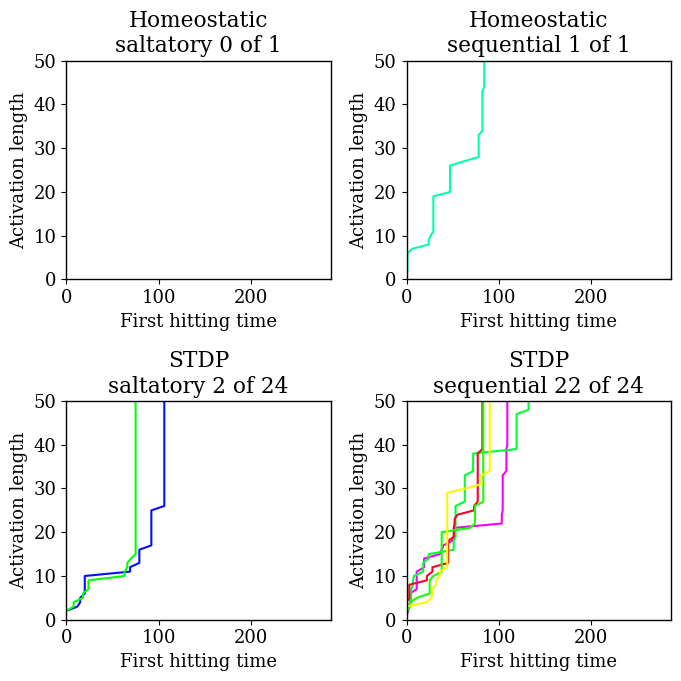

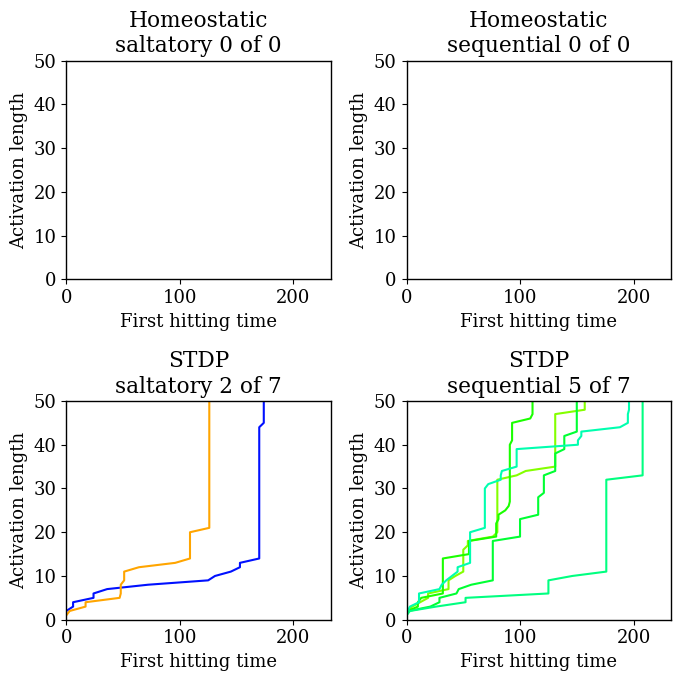

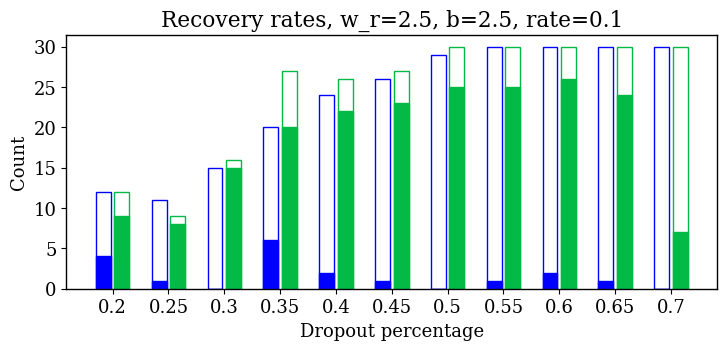

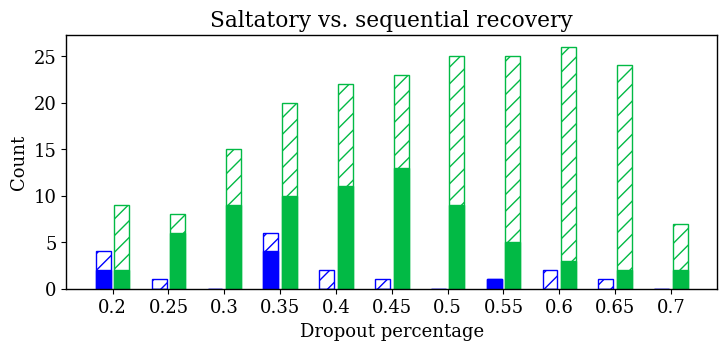

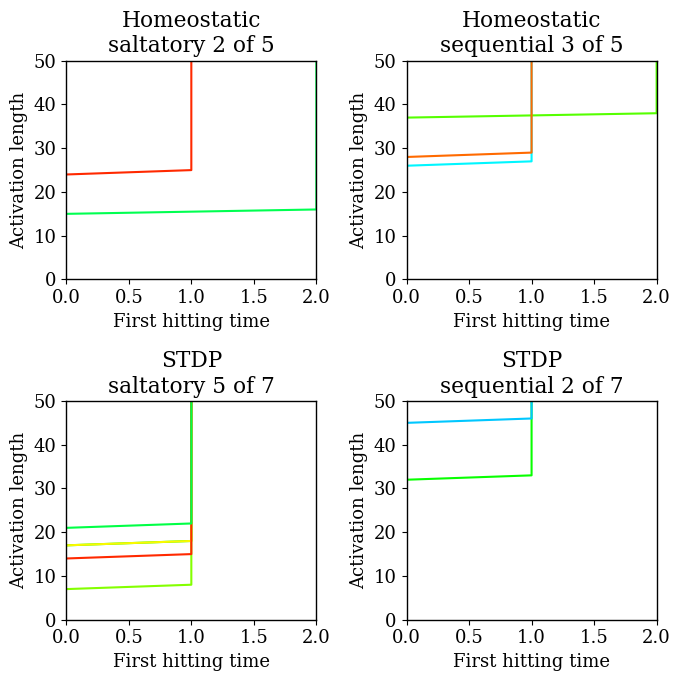

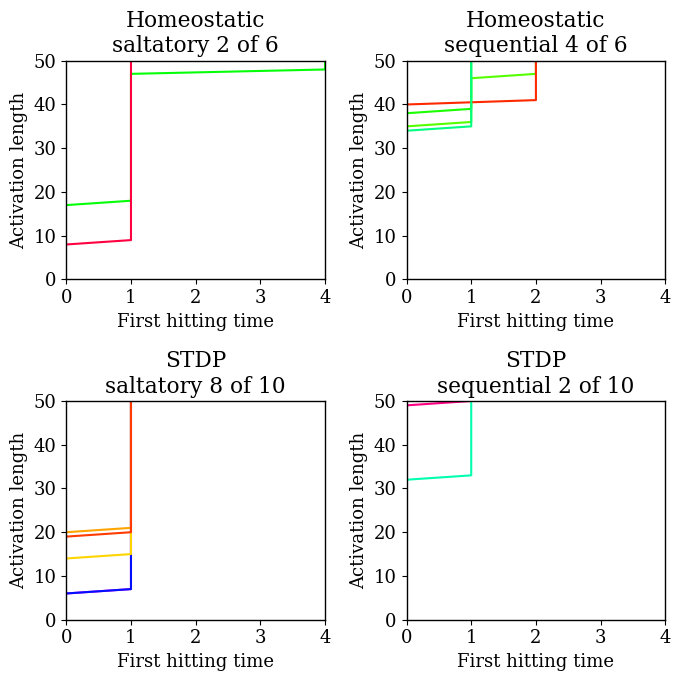

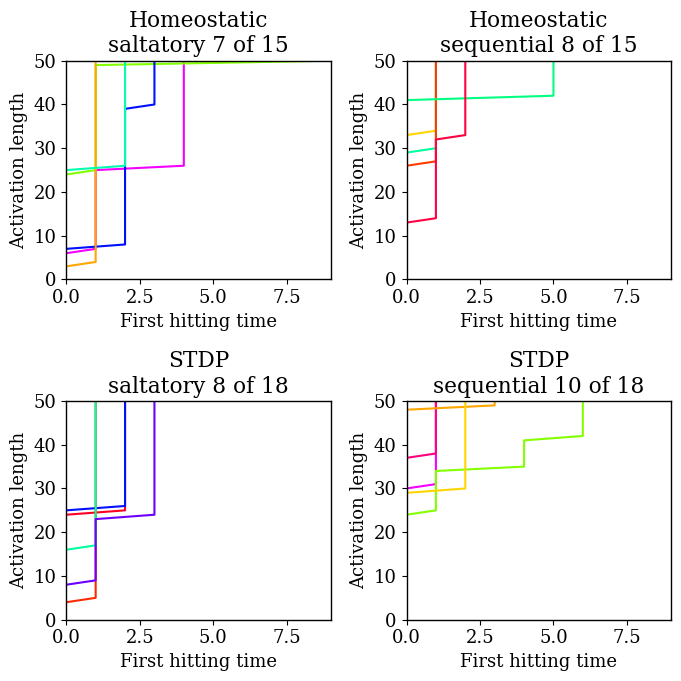

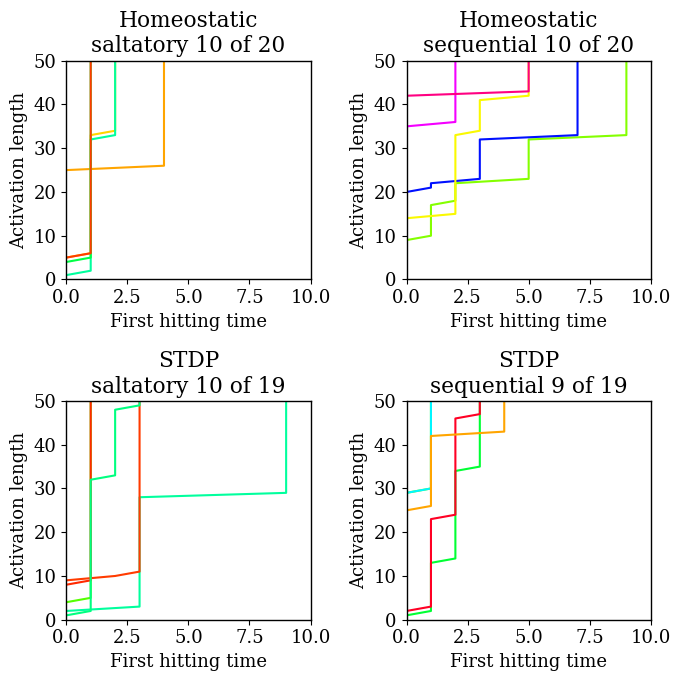

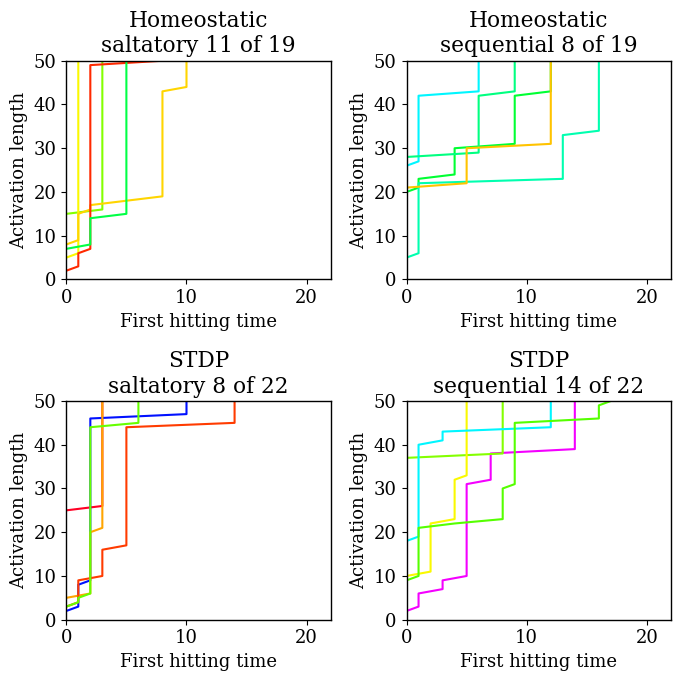

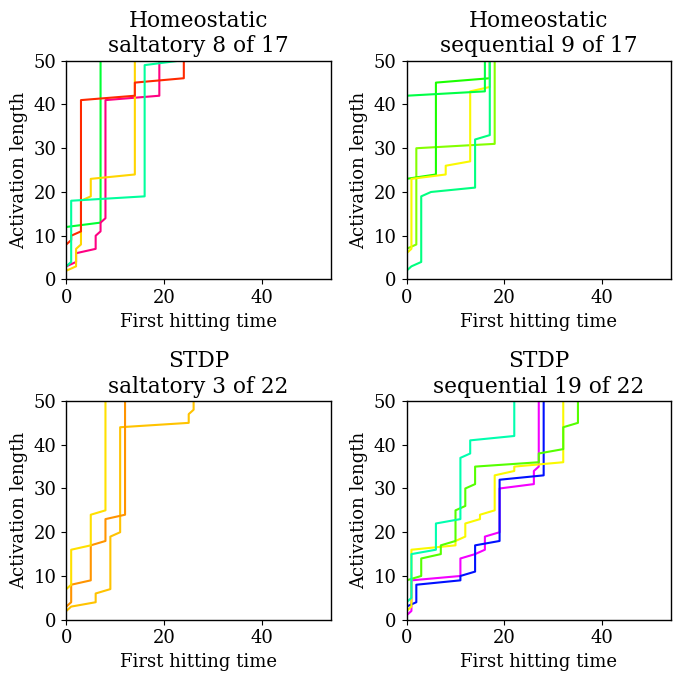

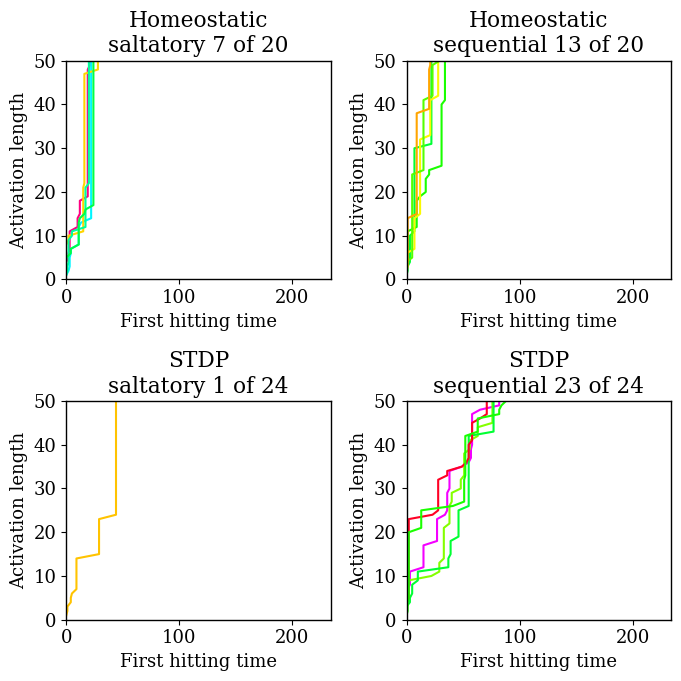

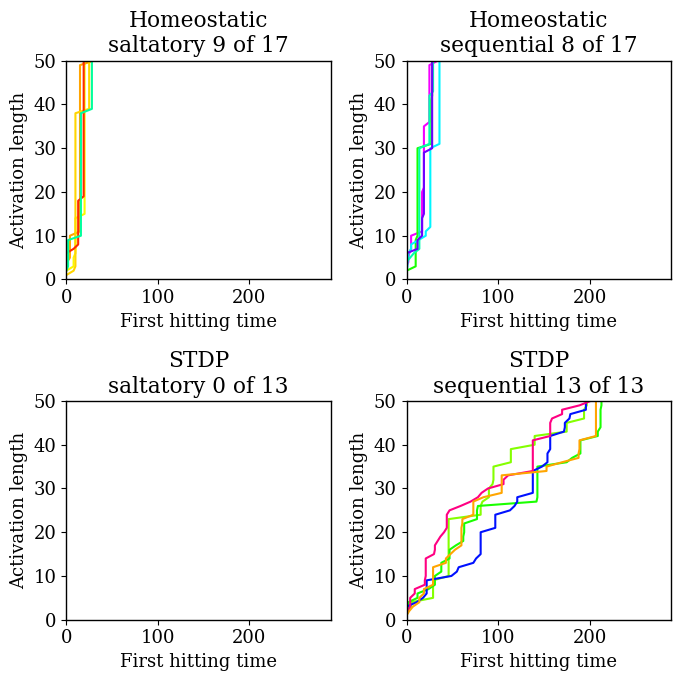

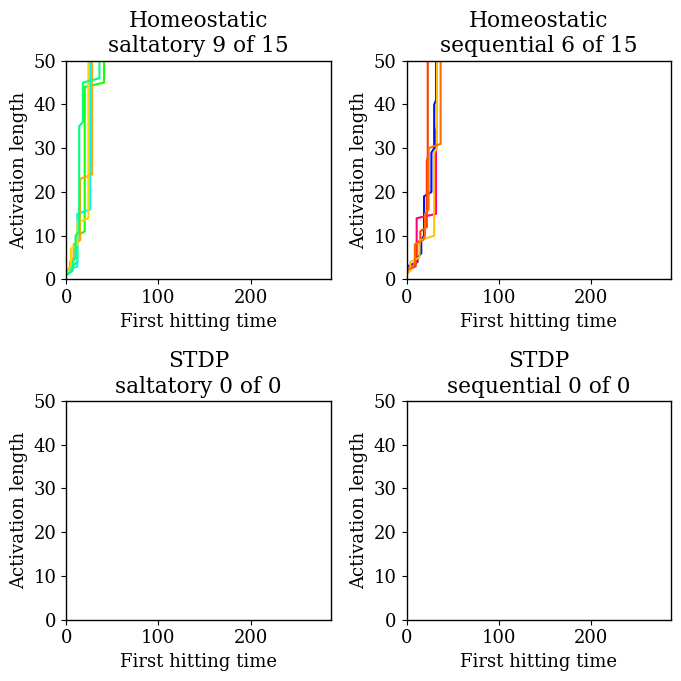

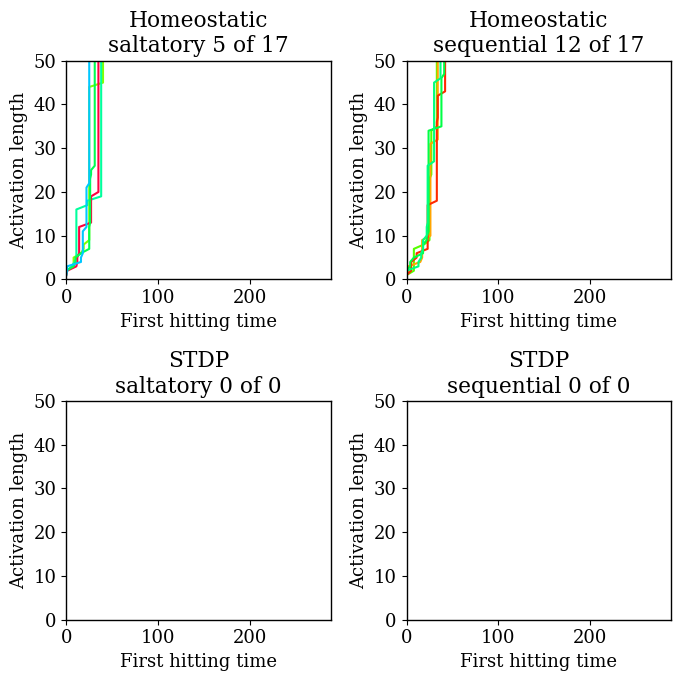

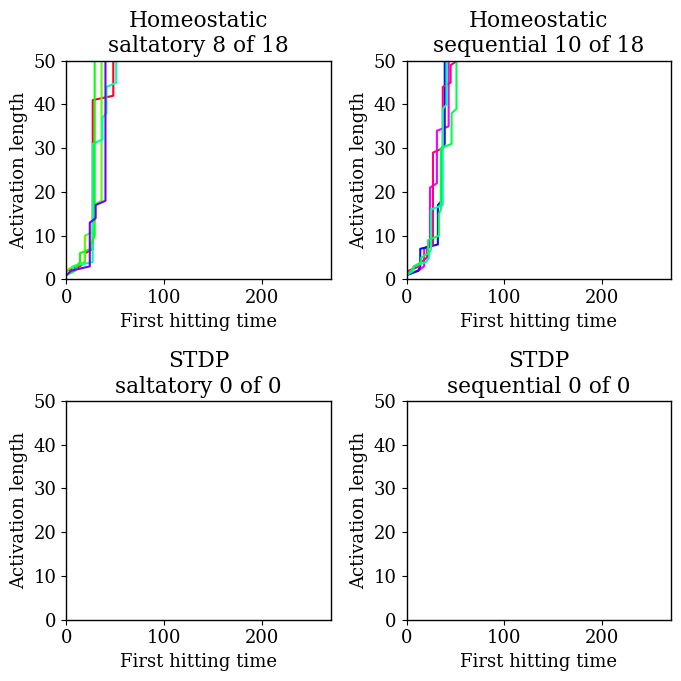

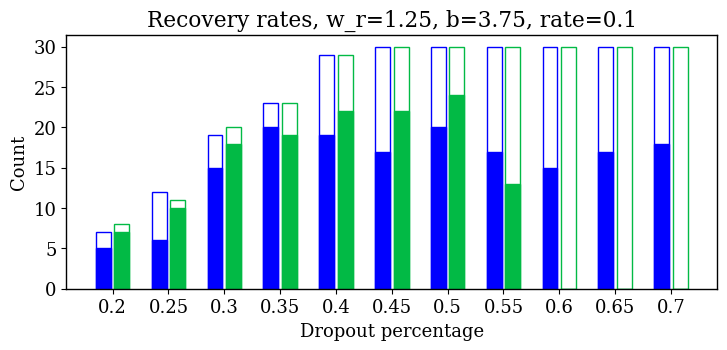

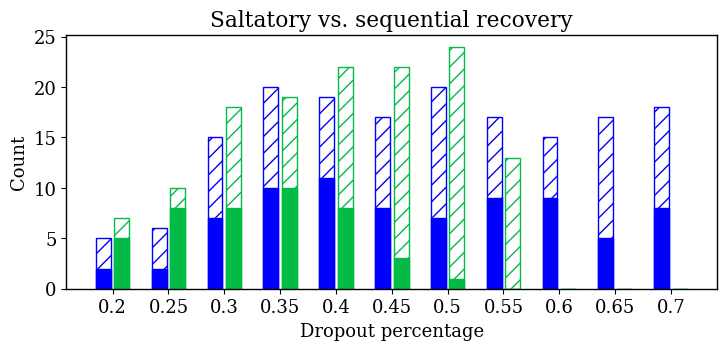

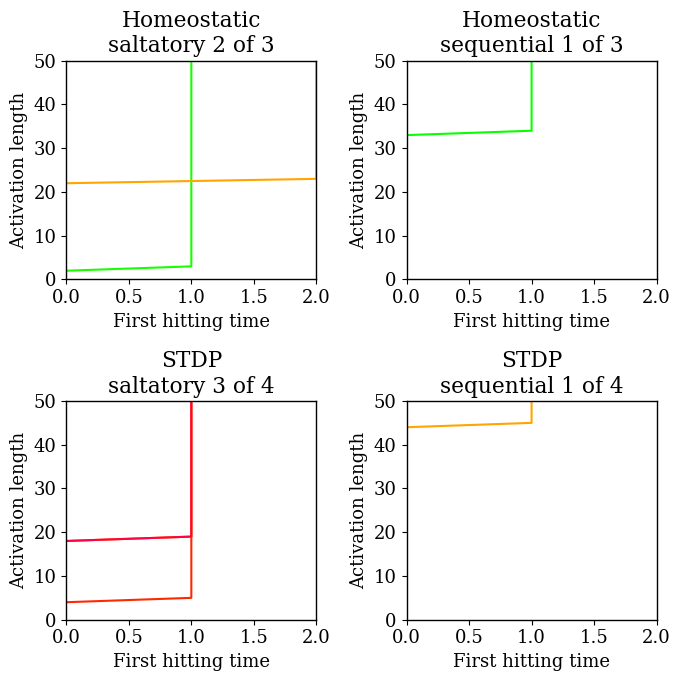

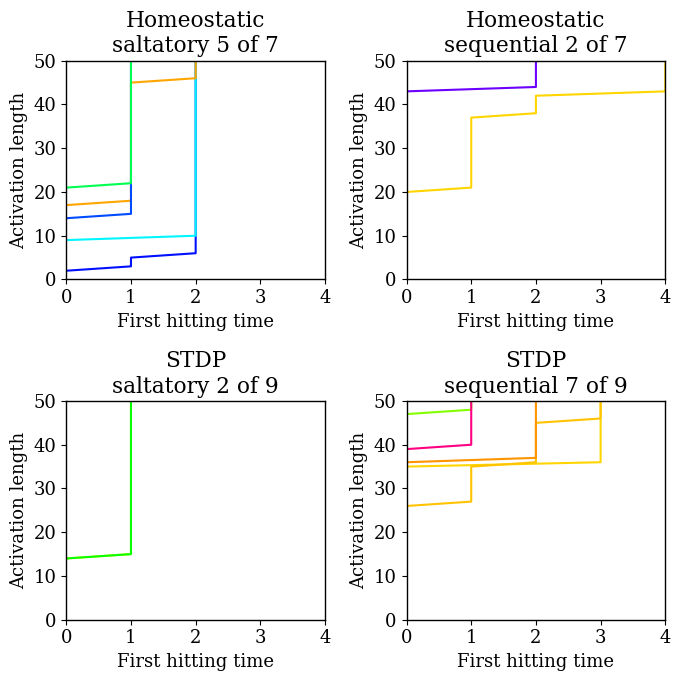

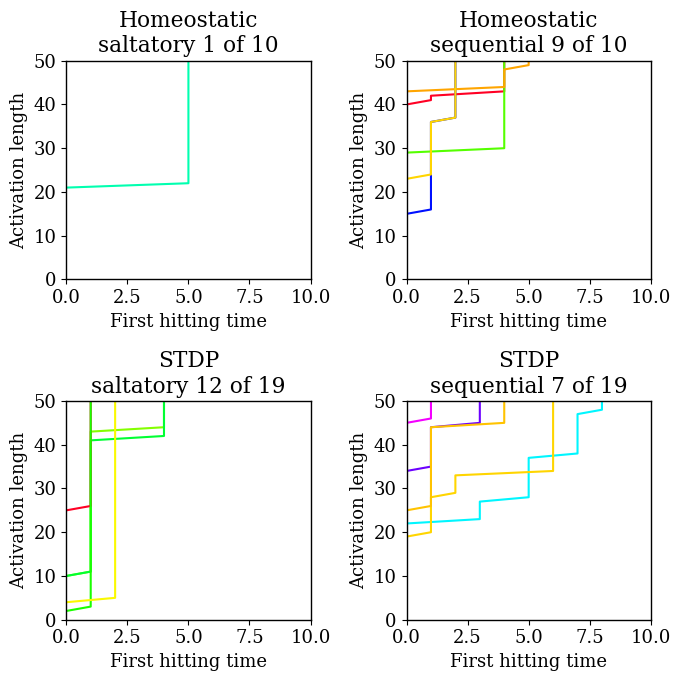

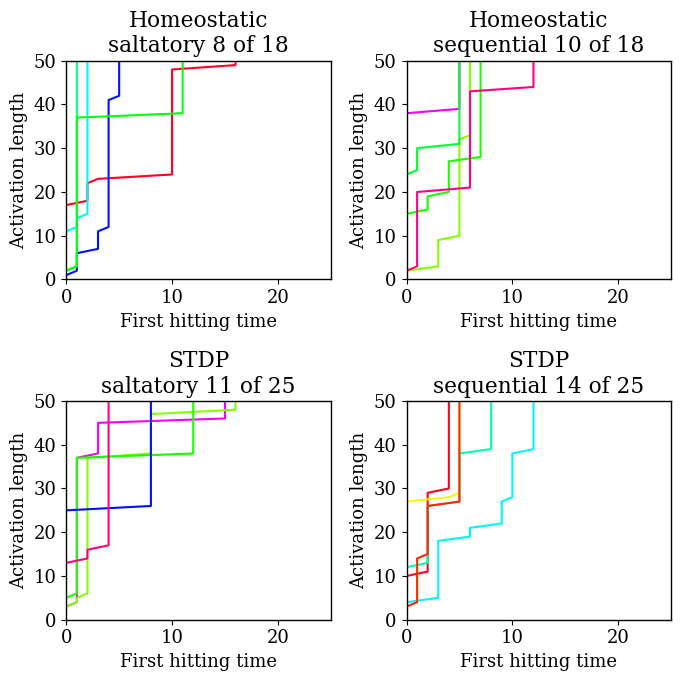

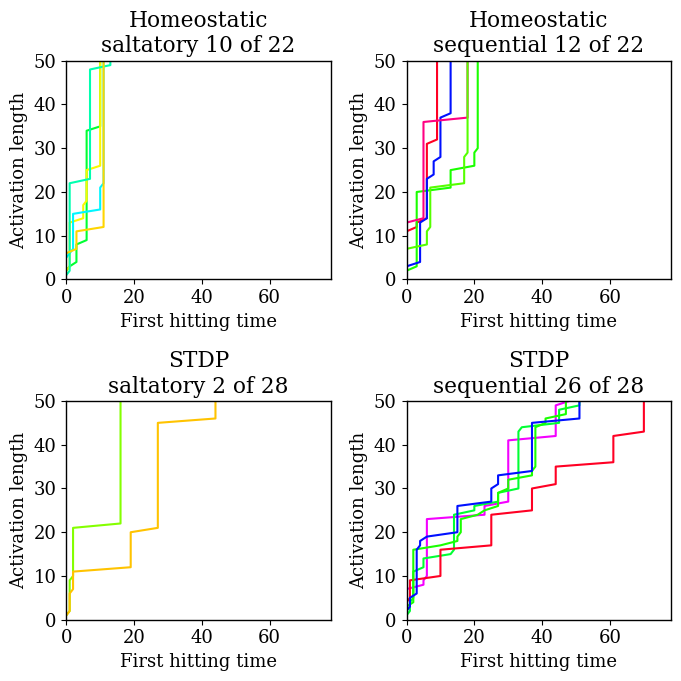

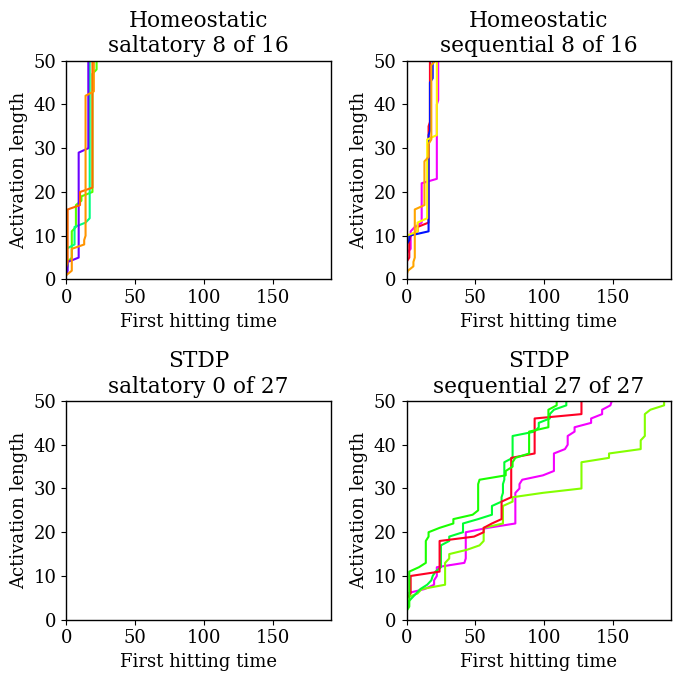

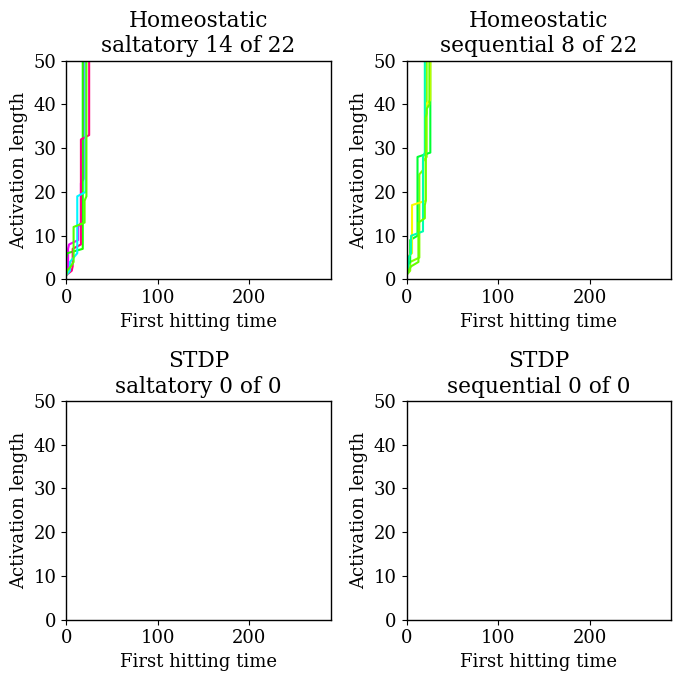

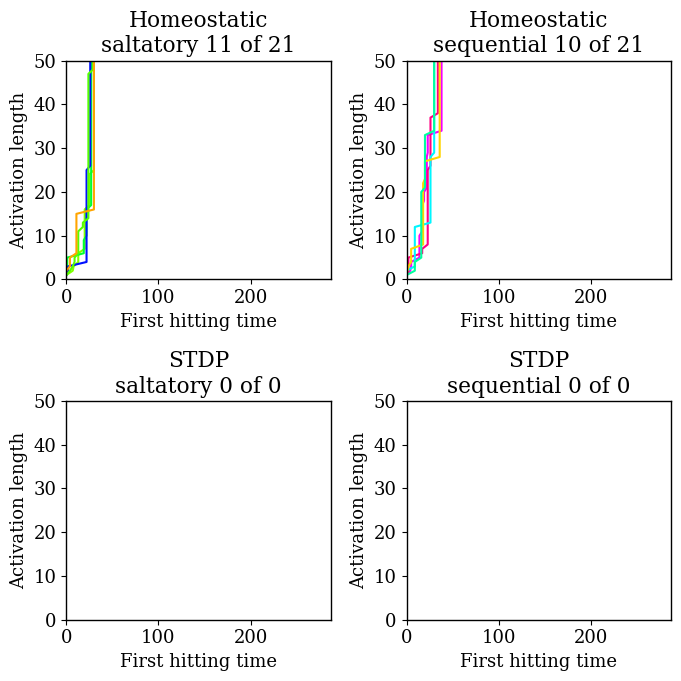

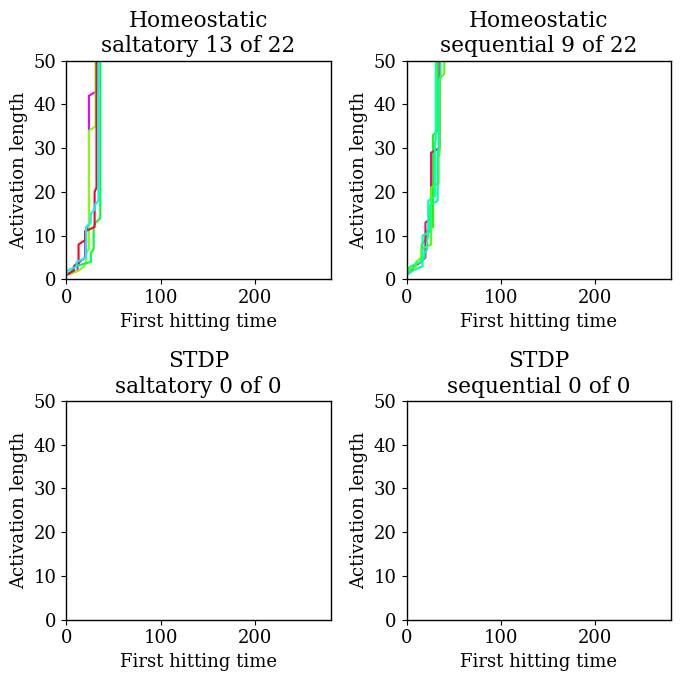

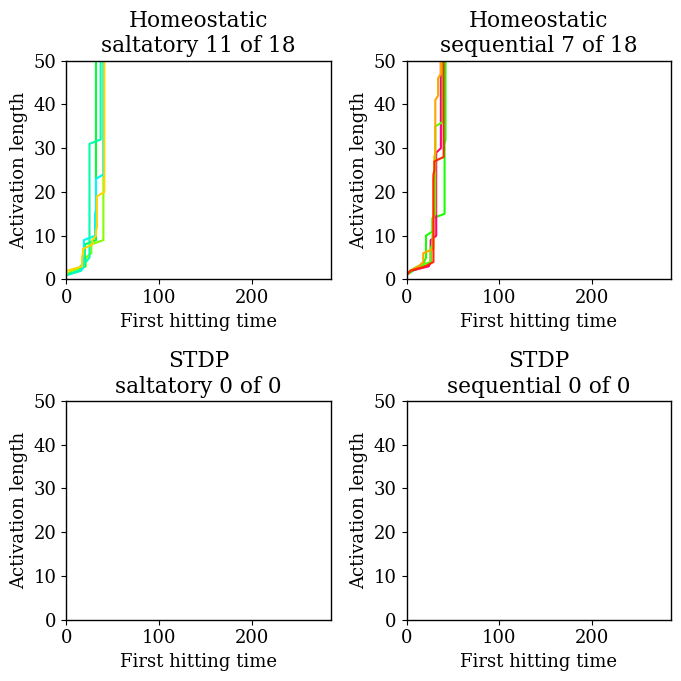

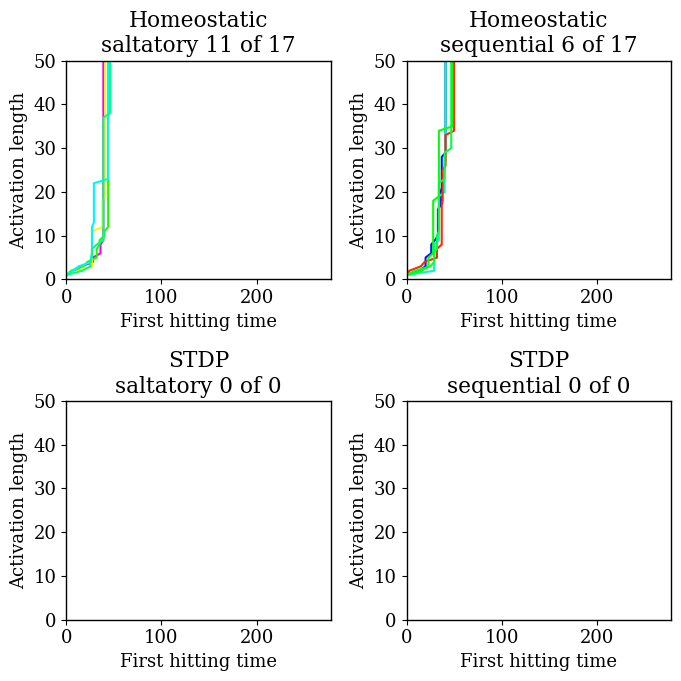

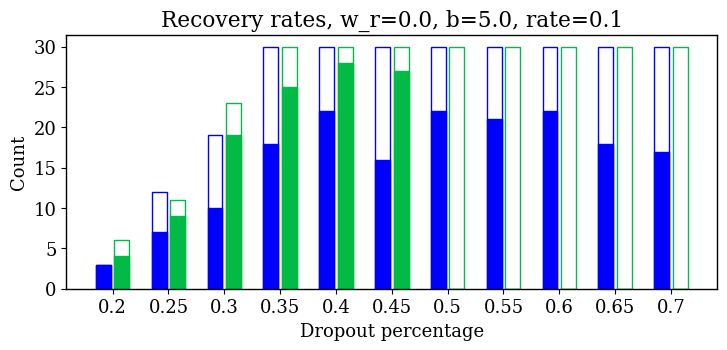

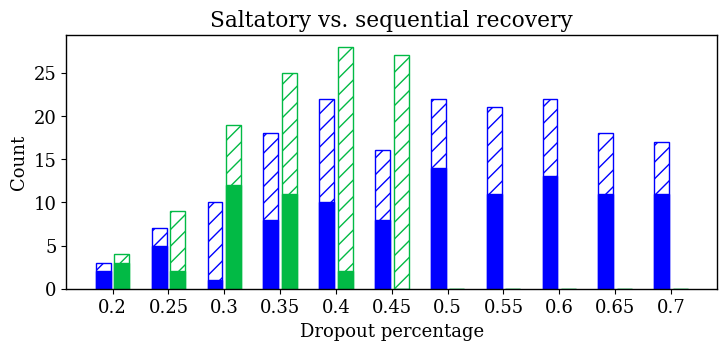

In [41]:
for i in range(0, len(df), 22):
    sub_df = df[i:i+22]
    df_homeostatic = sub_df[sub_df['rule'] == 'homeostatic']
    df_stdp = sub_df[sub_df['rule'] == 'stdp']

    a_shape = literal_eval(list(df_homeostatic['activations_shape'])[0])
    w_r = df_homeostatic['w_r'].iloc[0]
    b = df_homeostatic['b'].iloc[0]
    rate = df_homeostatic['rate'].iloc[0]

    activations_homeostatic = [np.array(a).reshape(a_shape) for a in list(df_homeostatic['activations'].apply(lambda x: json.loads(x)))]
    activations_stdp = [np.array(a).reshape(a_shape) for a in list(df_stdp['activations'].apply(lambda x: json.loads(x)))]

    plot_salt_vs_seq_statistics(activations_homeostatic, activations_stdp, subtitle=f', w_r={w_r}, b={b}, rate={rate}', plot_runs=True)